Este Notebook contém minhas anotações, e é baseado no original disponível em: https://www.kaggle.com/code/phelpsmemo/cap-351-neurocomputacao-projeto3-gng

# Projeto 3 - Experimentos com a rede Growing Neural Gas (GNG)

**Descrição do projeto**: No projeto 3 deve ser denvolvimento um cojunto de experimentos com a rede GNG, variando seus hiperparãmetros para o entendimento da influência de cada um deles no processo de aprendizado da rede. Para esta atividade, devem ser considerados inicialmente os parâmetros: **Limite de idade para as conexões**, **Tempo para adição de novos neurônios ($\lambda$)** e **Número máximo de neurônios**. 

> Ao longo do desenvolvimento da atividade, outros parâmetros podem ser considerados.

Os experimentos devem ser realizados em ao menos **três** conjuntos de dados diferentes.

> **Nota**: Nas descrições feitas neste documento é utilizado a palavra `simulação` para fazer referência a definição e treinamento de um modelo GNG. Tal definição foi feita para evitar ambiguidade com as palavras `execução` e `teste`. 


**Biblioteca base**

O desenvolvimento desta atividade foi realizado com o auxílio da biblioteca [NeuPy](http://neupy.com/pages/home.html), que fornece a implementação e exemplos de uso da rede GNG original [(Fritzke, 1994)](https://dl.acm.org/doi/10.5555/2998687.2998765), não tendo implementado o **Termo de utilidade**.

> Com o objetivo de tornar a reprodução deste trabalho possível, abaixo é feita a definição da *seed* de geração de números aleatórios.


In [1]:
RANDOM_STATE = 777

In [2]:

# Instalando a biblioteca NeuPy (Não está disponível por padrão no ambiente do Kaggle, utilizado para o 
# desenvolvimento deste trabalho).
!pip install neupy > /dev/null

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-cloud 0.1.9 requires tensorflow<3.0,>=1.15.0, but you'll have tensorflow 1.13.2 which is incompatible.
pytorch-lightning 1.0.6 requires tensorboard>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
mxnet 1.7.0.post1 requires graphviz<0.9.0,>=0.8.1, but you'll have graphviz 0.5.1 which is incompatible.
catalyst 20.11 requires tensorboard>=1.14.0, but you'll have tensorboard 1.13.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import copy
from math import sqrt

import numpy as np
import pandas as pd

import sklearn.datasets
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

from neupy import algorithms, utils

# Configurando seed do Numpy/NeuPy
np.random.seed(RANDOM_STATE)
utils.reproducible(RANDOM_STATE)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

**Funções auxiliares**

Nesta seção são feitas as definições de funções auxiliares para a visualização e manipulação dos dados. 

> As funções listadas abaixo foram criadas com o auxílio da documentação do [NeuPy](http://neupy.com/pages/home.html). 


In [4]:
# Constantes padrão de estilo para a função de visualização dos modelos GNG
DEFAULT_SCATTER_KWARGS = {'color': 'k', 'zorder': 1000, 's': 5}
DEFAULT_PLOT_KWARGS = {'linewidth': 1, 'color': 'k', 'zorder': 500}


def graph_edge(node_1, node_2, dimensions: tuple, **kwargs):
    """Função para plotar a ligação de dois nós em um grafo.
    
    Args:
        node_1 (neupy.NeuronNode): Primeiro neurônio envolvido na ligação
        
        node_2 (neupy.NeuronNode): Segundo neurônio envolvido na ligação
        
        dimensions (tuple): Dimensões consideradas no plot (Posição da feature)
        
        kwargs (dict): Argumentos extras para a função matplotlib.pyplot.plot
        
    Returns:
        matplotlib.pyplot.Axes: Instância criada para representar o nó na figura
        
    See:
        https://github.com/itdxer/neupy/blob/master/notebooks/growing-neural-gas/Growing%20Neural%20Gas%20-%20step%20by%20step%20visualizations.ipynb
    """
    
    weights = np.concatenate([node_1.weight[:, dimensions], 
                              node_2.weight[:, dimensions]])
    return plt.plot(*weights.T, **kwargs)


def graph(graph, dimensions, scatter_kwargs = None, plot_kwargs = None):
    """Função para gerar a visualização de um grafo não direcionado. A função
    foi criada para representar a estrutura interna do NeuPy para representar os nós da rede GNG
    
    Args:
        graph (neupy.NeuralGasGraph): Grafo não direcionado com as relações de cada neurônio 
        
        dimensions (tuple): Dimensões consideradas no plot (Nome da feature)
        
        scatter_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.scatter 
        utilizada para representar cada neurônio
        
        plot_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.plot utilizada para cada conexão
    
    Returns:
        None
        
    See:
        https://github.com/itdxer/neupy/blob/master/notebooks/growing-neural-gas/Growing%20Neural%20Gas%20-%20step%20by%20step%20visualizations.ipynb
    """

    if not plot_kwargs:
        plot_kwargs = {'color': 'black', 'alpha': 1, 'zorder': 500}
    if not scatter_kwargs:
        scatter_kwargs = {'color': 'red', 'zorder': 1000, 's': 160}
        
    if 'zorder' not in scatter_kwargs:
        scatter_kwargs['zorder'] = 1000
    if 'zorder' not in plot_kwargs:
        plot_kwargs['zorder'] = 500
    
    for node_1, node_2 in graph.edges:
        graph_edge(node_1, node_2, dimensions, **plot_kwargs)
        
    weights = np.concatenate([node.weight[:, dimensions] for node in graph.nodes])
    plt.scatter(*weights.T, **scatter_kwargs)

    
def get_2d_position(feature_names, list_of_all_feature_names_avaliable):
    """Função criada para recuperar de maneira facilitada a dimensão que está sendo
    tratada para a visualização da GNG. Esta função foi feita para tornar possível a consideração
    de que, as operações realizadas pela rede consideram múltiplas dimensões
    
    Args:
        feature_names (tuple): Tupla com as duas dimensões que estão sendo consideradas na visualização
        
        list_of_all_feature_names_avaliable (list): Lista com todos os nomes de features presentes no conjunto
        de dados
    Returns:
        tuple: Tupla com a posição das dimensões
    """
    return list((list_of_all_feature_names_avaliable.index(feature_name) for feature_name in feature_names))


def show_gng_models(gng_models, 
                          gng_models_labels, 
                          dimensions,
                          background_spec,
                          grid_spec, 
                          title_size = 12,
                          plot_kwargs = DEFAULT_PLOT_KWARGS,
                          scatter_kwargs = DEFAULT_SCATTER_KWARGS):
    """Função para facilitar a visualização com múltiplos plots de modelos GNG
    
    Args:
        gng_models (list): Lista com os modelos GNG treinados
        
        gng_models_labels (list): Lista de strings com o título de cada modelo
        
        dimensions (tuple): Posição dos atributos utilizados na visualização
        
        background_spec (dict): Dicionário com as chaves ['data', 'x', 'y', 'label']. Utilizado
        para criar um plano de fundo ao plot de modelo gerado
        
        grid_spec (tuple): Especificação do grid onde os subplots serão realizados
        
        title_size (int): Tamanho da fonte do título
        
        scatter_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.scatter 
        utilizada para representar cada neurônio
        
        plot_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.plot utilizada para cada conexão
    Returns:
        None
    """

    idx = 1 
    for i in range(1, len(gng_models) + 1):
        ax = plt.subplot(grid_spec[0], grid_spec[1], idx)

        background_spec['data'].plot.scatter(
            background_spec['x'], background_spec['y'], 
            c = background_spec['label'], alpha = 0.6, ax = ax,
            cmap = background_spec['cmap']
        )
        
        graph(gng_models[idx - 1].graph, dimensions, 
              scatter_kwargs = scatter_kwargs,
              plot_kwargs = plot_kwargs)

        plt.title(gng_models_labels[idx - 1], fontdict = {'fontsize': title_size}); idx += 1
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    

def generate_title_names(name_pattern, values, **kwargs):
    """Função auxiliar para gerar títulos de subfiguras utilizando 
    o nome da propriedade e o valor
    
    Args:
        name_pattern (str): Nome da propriedade que deve ser vinculada aos valores (string pattern com propriedade `value` disponível). e. g. test = {value}
        
        values (list): Lista de valores
    Returns:
        list: Lista de string que vincula a propriedade com o valor aplicado
    """
    return [name_pattern.format(value = value, **kwargs) for value in values]
    

### Experimento 1 - Iris *dataset*

Para o desenvolvimento deste primeiro experimento, será feito o uso do conjunto de dados *iris*, disponibilizado no [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/iris). O conjunto de dados contém 150 instâncias com 4 atributos (Comprimento/Largura da sépalas e pétalas). Cada uma dessas instâncias está associada a uma determinada classe, que indica a espécie da planta (Setosa, Virginica e Versicolor).

Este primeiro experimento busca explorar a geração e apresentação das redes GNG.


**Importação do conjunto de dados**

Para tornar o processo de aquisição dos dados mais simples, será feito o uso da função `load_iris` presente no módulo `datasets` da biblioteca [scikit-learn](https://scikit-learn.org/stable/).

In [5]:
iris = sklearn.datasets.load_iris()

# Simplificando o nome de cada um dos atributos
feature_names = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']

Com os dados carregados, faz-se a criação de uma tabela com os dados através do uso da biblioteca [Pandas](https://pandas.pydata.org/). A tabela será representada com um `pandas.core.DataFrame`.

In [6]:
irisdf = pd.DataFrame(iris.data, columns = feature_names)
irisdf['label'] = iris.target

irisdf.head(n = 5)

sepal_len  sepal_wid  petal_len  petal_wid  label
0        5.1        3.5        1.4        0.2      0
1        4.9        3.0        1.4        0.2      0
2        4.7        3.2        1.3        0.2      0
3        4.6        3.1        1.5        0.2      0
4        5.0        3.6        1.4        0.2      0

Como forma de apresentar a relação e distribuição de cada uma das instâncias e seus atributos, abaixo é feito o uso da função `pairplot`, disponibilizada pela biblioteca [Seaborn](https://seaborn.pydata.org/), que apresenta ambas as informações mencionadas em uma única figura.

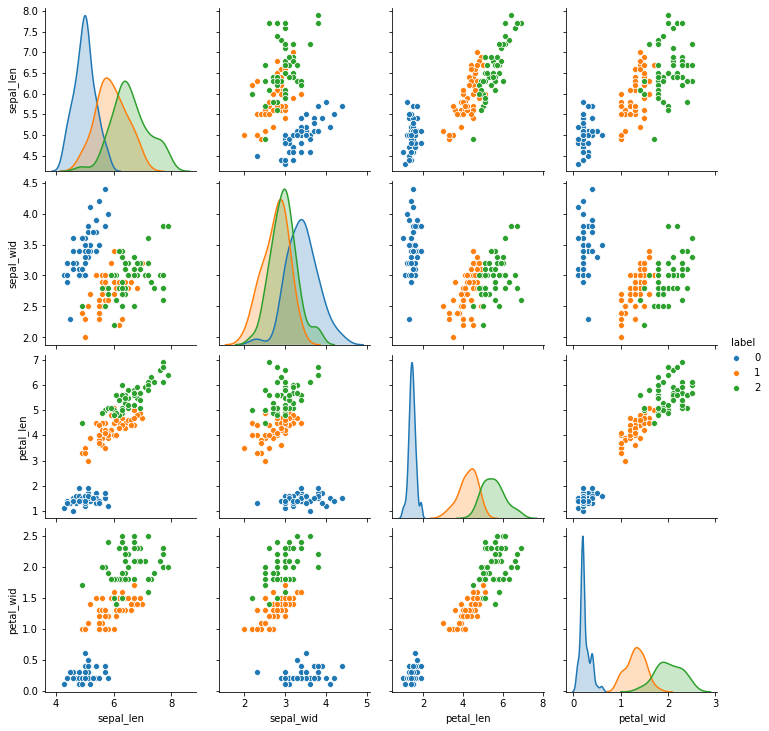

In [7]:
sns.pairplot(irisdf, hue = 'label')

#### Teste 1 - Quantidade máxima de neurônios

Neste primeiro teste será realizada a avaliação do comportamento da rede frente a mudança da `quantidade de neurônios máximos`. Para isto, será feita a variação do parâmetro `max_nodes`, presente no inicializador da classe `neupy.algorithms.GrowingNeuralGas`.

> Assim como apresentado na documentação do [NeuPy](http://neupy.com/pages/home.html), cabe citar que este parâmetro limita a quantidade de neurônios, mas, caso esta seja atingida, o treinamento não é finalizado. 

> O valor padrão do parâmetro `max_nodes` é 1000.

A avaliação será feita considerando valores crescentes, sendo considerados: $[1, 3, 5, 10, 50, 100, 250, 500, 1000]$. Para começar, é feita a criação das instâncias da classe `neupy.algorithms.GrowingNeuralGas` com as diferentes configurações de `max_nodes`.


In [8]:
test1_max_nodes = [1, 3, 5, 10, 50, 100, 250, 500, 1000]

gng_models = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(iris.feature_names), # Dimensões = Quantidade de atributos em cada instância
        n_start_nodes = 2, 
        
        max_nodes = mnode
    ) for mnode in test1_max_nodes
]

Feito isto, cada um dos modelos criados é treinado utilizando 500 `epochs`.

> Para o treinamento, a coluna `label` é removida do conjunto de dados.


In [9]:
[gng_model.train(irisdf.iloc[:, 0:4], epochs = 500) for gng_model in gng_models]

[None, None, None, None, None, None, None, None, None]

Com os modelos treinados, faz-se a criação da visualização de cada um dos resultados.

> Em todos os exemplos apresentados na documentação do [NeuPy](http://neupy.com/pages/home.html), faz-se o uso de modelos com apenas dois atributos, para tornar possível a visualização da topologia gerada através de um **scatter-plot**. Ao contrário disso, para a realização dos experimentos neste documento será feita a criação de modelos considerando todos os atributos disponíveis, gerando neurônios compostos por *N* dimensões. Na etapa de visualização desses modelos, por outro lado, para tornar a apresentação mais simples, é feito o uso de apenas duas dimensões no espaço de atributos.

> Esta visualização é feita com a função auxiliar `show_gng_models`, que recebe os modelos e as dimensões que serão visualizadas. As dimensões devem ser passadas para a função `show_gng_models` em um formato de índice, de modo que para cada neurônio seja feito o uso do valor correspondente ao índice definido. Para a extração desses índices fez-se a criação da função `get_2d_position`, que devolve o índice que deve ser utilizado para cada dimensão que está sendo declarada.

Para este primeiro teste, os resultados serão apresentados utilizando as dimensões `sepal_len` e `petal_len`.

In [10]:
dims = get_2d_position(['sepal_len', 'petal_len'], feature_names)
dims  # Posição dos dados que devem ser utilizados na figura gerada

[0, 2]

Abaixo é feita a visualização das topologias geradas em cada uma das simulações.

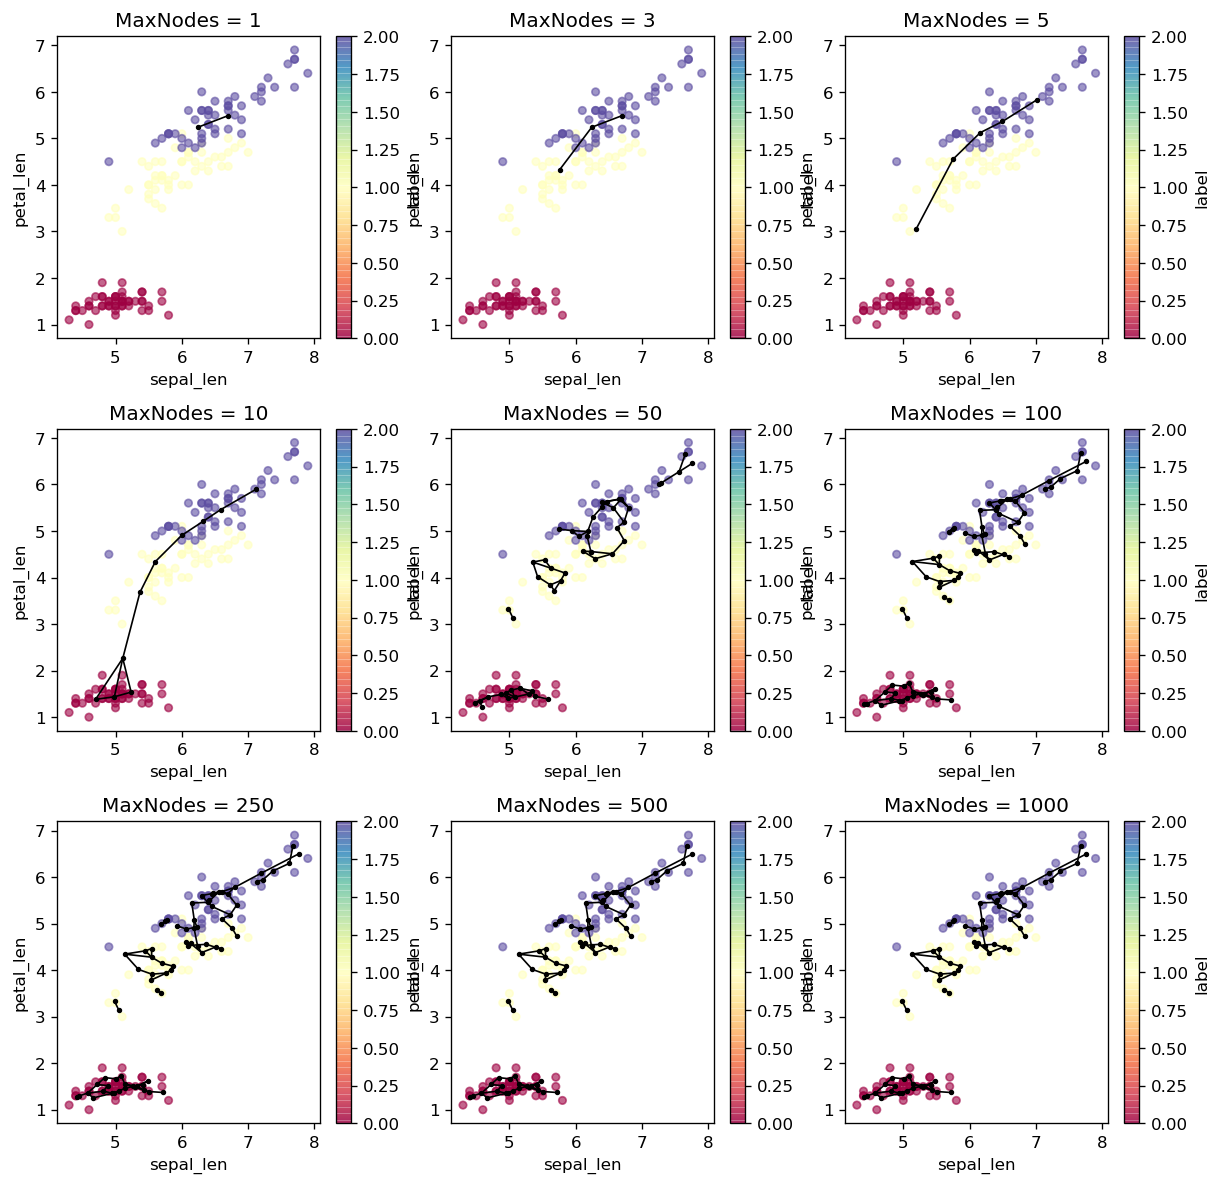

In [11]:
fig = plt.figure(figsize = (12, 12), dpi = 120)
title_names = generate_title_names("MaxNodes = {value}", test1_max_nodes)

cmap = plt.cm.get_cmap('Spectral')
show_gng_models(gng_models, title_names, dims, {
    'data': irisdf,
    'x': 'sepal_len',
    'y': 'petal_len',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Com a visualização apresentada acima é possível perceber que o aumento na `quantidade máxima de neurônios` fez o processo de treinamento criar topologias com neurônios mais heterogêneos do que os vistos nas baixas `quantidades de neurônios máximos`. Por exemplo, para os testes com poucas quantidades de neurônios (`1`, `3` e `5`), toda a representação estava sendo feita por uma pequena quantidade de neurônios, o que resultou uma topologia muito geral aos atributos. Ao contrário disto, com o aumento na quantidade de neurônios veio também o aumento na especialização das representações que estavam sendo feitas, como ocorre para os elementos `Amarelos`, que chegam a ter representações individuais. 

Vale notar também os elementos `Vermelhos`, que são representados por um conjunto de neurônios que não tem ligação com os neurônios de outras classes, o que é explicado pela não ativação simultânea deste padrão com os demais. Este é um comportamente que não ocorre com os elementos `Amarelo` e `Roxo`, já que estes possuem uma certa mistura, como pode ser observado no resultado e confirmado na figura de relação e distribuição.


#### Teste 2 - Idade máxima das conexões ($a_{max}$)

Enquanto o primeiro teste estava sendo realizado, uma pergunta surgiu: "Como as topologias geradas no primeiro teste se comporta caso haja a variação na idade máxima das conexões?". Com base nesta questão, este segundo teste será desenvolvido. Para isso, é realizado o treinamento de um modelo com `quantidade máxima` de 1000 neurônios, variando as quantidades de iterações ($a_{max}$) que devem ser consideradas para a exclusão da conexão entre dois neurônios. 

> O modelo com quantidade máxima de 1000 neurônios foi selecionado por conta da grande quantidade de conexões e detalhes que podem ser gerados, como pode ser visto no teste anterior.

O parâmetro que controla a **idade máxima das conexões** na classe `neupy.algorithms.GrowingNeuralGas` é o `max_edge_age`, que especifica a idade máxima utilizando a quantidade de iterações.. Neste teste as variações serão feitas considerando os valores $[10, 25, 50, 100, 150, 500]$. Os modelos são gerados abaixo.

> O valor padrão do parâmetro `max_edge_age` na biblioteca [NeuPy](http://neupy.com/pages/home.html) é `100`.


In [12]:
test2_max_edge_age = [10, 25, 50, 100, 150, 500]

gng_models_test2 = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(iris.feature_names), 
        n_start_nodes = 2, 
        
        max_nodes = 1000,
        max_edge_age = max_age  # Idade máxima
    ) for max_age in test2_max_edge_age
]

Agora, cada um dos modelos é treinado. A mesma quantidade de `epochs` consideradas no teste anterior é aplicada (500 `epochs`), para que, se necessário, comparações possam ser realizadas.

In [13]:
[gng_model.train(irisdf.iloc[:, 0:4], epochs = 500) for gng_model in gng_models_test2]

[None, None, None, None, None, None]

Abaixo, as topologias geradas são apresentadas.

> A apresentação dos resultados feita abaixo utiliza dos atributos `sepal_len` e `petal_len` para a apresentação no plano bidimensional.


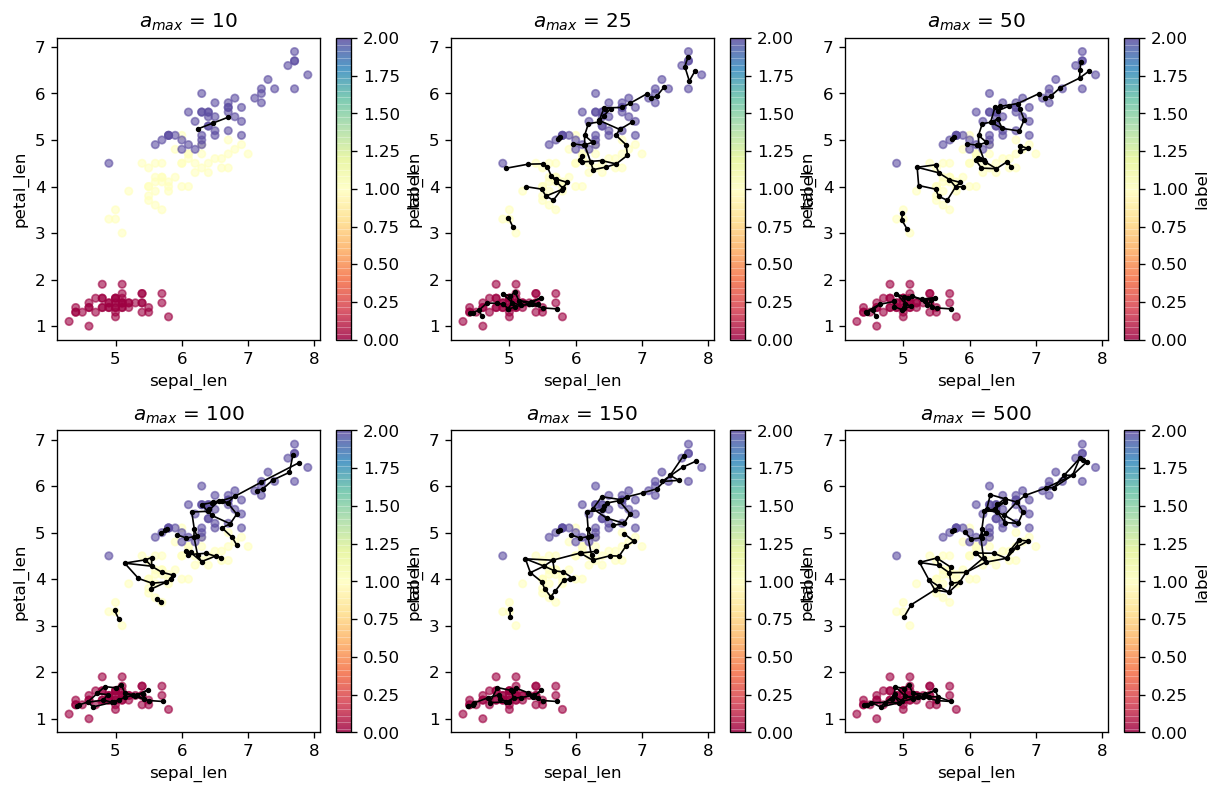

In [14]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

dims_test2 = get_2d_position(['sepal_len', 'petal_len'], feature_names)
title_names = generate_title_names("$a_{mmx}$ = {value}", test2_max_edge_age, mmx="{max}")

show_gng_models(gng_models_test2, title_names, dims_test2, {
    'data': irisdf,
    'x': 'sepal_len',
    'y': 'petal_len',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Ao analisar a figura nota-se que para os mapas ajustados com uma quantidade menor de `idade máxima das conexões`, há grupos de neurônios mais específicos e isolados, podendo este comportamento ser o resultado da adição de neurônios em regiões que não são mais ativadas, o que junto com a pequena quantidade de tempo de vida das conexões acabou gerando tais neurônios isolados. Ao contrário deste comportamento, para as quantidades maiores de `idade máxima das conexões`, muitas conexões foram mantidas, já que estas, mesmo sendo geradas para comportamentos específicos que podem não estar mais recebendo atualizações, estão sendo mantidas por longos períodos no mapa.

> Para o segundo caso, pode ser que haja a necessidade do aumento da quantidade `epochs` para que exista uma convergência melhor do mapa para os comportamentos que estão sendo apresentados.

Como forma de testar a influência da quantidade de `epochs` neste processo, o mapa gerado com `idade máxima das conexões` com valor 150 será testado com 1000 `epochs`. 

> A seleção do modelo com `idade máxima das conexões` igual à 150 iterações foi feita considerando a velocidade e praticidade das execuções. Outras simulações foram realizados considerando o modelo de `idade máxima das conexões` = 500, porém, o processo de treinamento passou a ser muito demorado pela quantidade de `epochs` exigida.


In [15]:
model_max_edge_age_150_test2 = algorithms.GrowingNeuralGas(
    n_inputs = len(iris.feature_names), 
    n_start_nodes = 2, 
        
    max_nodes = 1000,
    max_edge_age = 150
)

model_max_edge_age_150_test2.train(irisdf.iloc[:, 0:4], epochs = 1000)

Abaixo, o modelo gerado será apresentado.

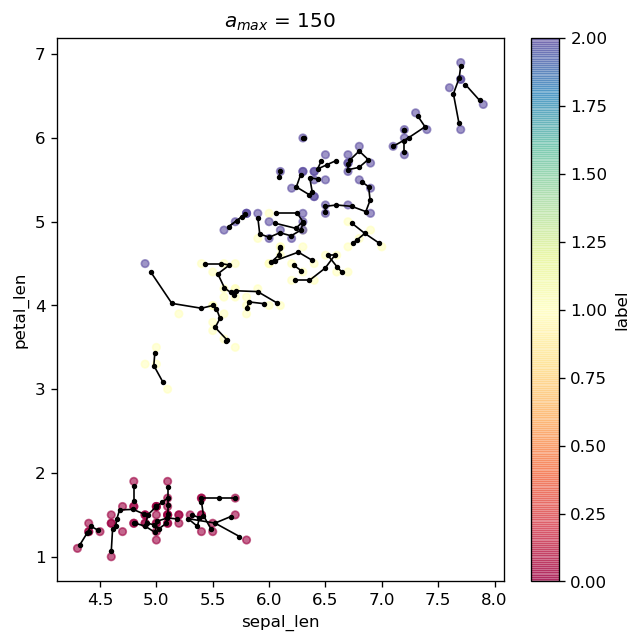

In [16]:
fig = plt.figure(figsize = (6, 6), dpi = 120)
title_names = generate_title_names("$a_{mmx}$ = {value}", [150], mmx="{max}")

# dims_test2 foi declarado na visualização anterior
show_gng_models([model_max_edge_age_150_test2], title_names, dims_test2, {
    'data': irisdf,
    'x': 'sepal_len',
    'y': 'petal_len',
    'label': 'label',
    'cmap': cmap
}, (1, 1))

Como pode ser percebido, e como esperado, ao aumentar a quantidade de `epochs`, deu-se ao processo de treinamento mais tempo para os ajustes necessários para a criação de grupos mais específicos de neurônios, removendo as conexões que não representam diversas ativações, gerando resultados semelhantes aos apresentados nos testes com valores menores de `idades máximas de conexões`.

> Desta forma, pode-se observar as diversas representações que podem ser criadas com a manipulação desses hiperparâmetros da rede GNG.


#### Teste 3 - Adição de novos neurônios ($\lambda$)

Como uma das características principais da rede GNG é a adaptação da topologia aos dados, o processo de adição de novos neurônios é extremamente importante. Neste teste é considerado a variação do `tempo para a adição de novos neurônios` ($\lambda$).

> Na classe `neupy.algorithms.GrowingNeuralGas`, o parâmetro responsável em realizar este controle é o `n_iter_before_neuron_added`, que permite especificar a quantidade de iterações que devem ser realizadas antes da adição de um novo neurônio.

Neste teste, tal parâmetro é variado considerando os seguintes valores $[5, 10, 100, 250, 500, 1000]$. Abaixo é feita a criação de cada um dos mapas.


In [17]:
test3_n_iter_before_neuron_added = [5, 10, 100, 250, 500, 1000]

gng_models_test3 = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(iris.feature_names), 
        n_start_nodes = 2, 
        shuffle_data = True,
        
        max_nodes = 1000,
        
        # número de iterações antes da adição de um
        # novo neurônio
        n_iter_before_neuron_added = max_n_inter

    ) for max_n_inter in test3_n_iter_before_neuron_added
]

Assim como nos dois primeiros testes, é feito o treinamento dos modelos considerando 500 `epochs`.

In [18]:
[gng_model.train(irisdf.iloc[:, 0:4], epochs = 500) for gng_model in gng_models_test3]

[None, None, None, None, None, None]

Uma vez tendo cada um dos mapas gerados, a visualização dos resultados é apresentada abaixo.

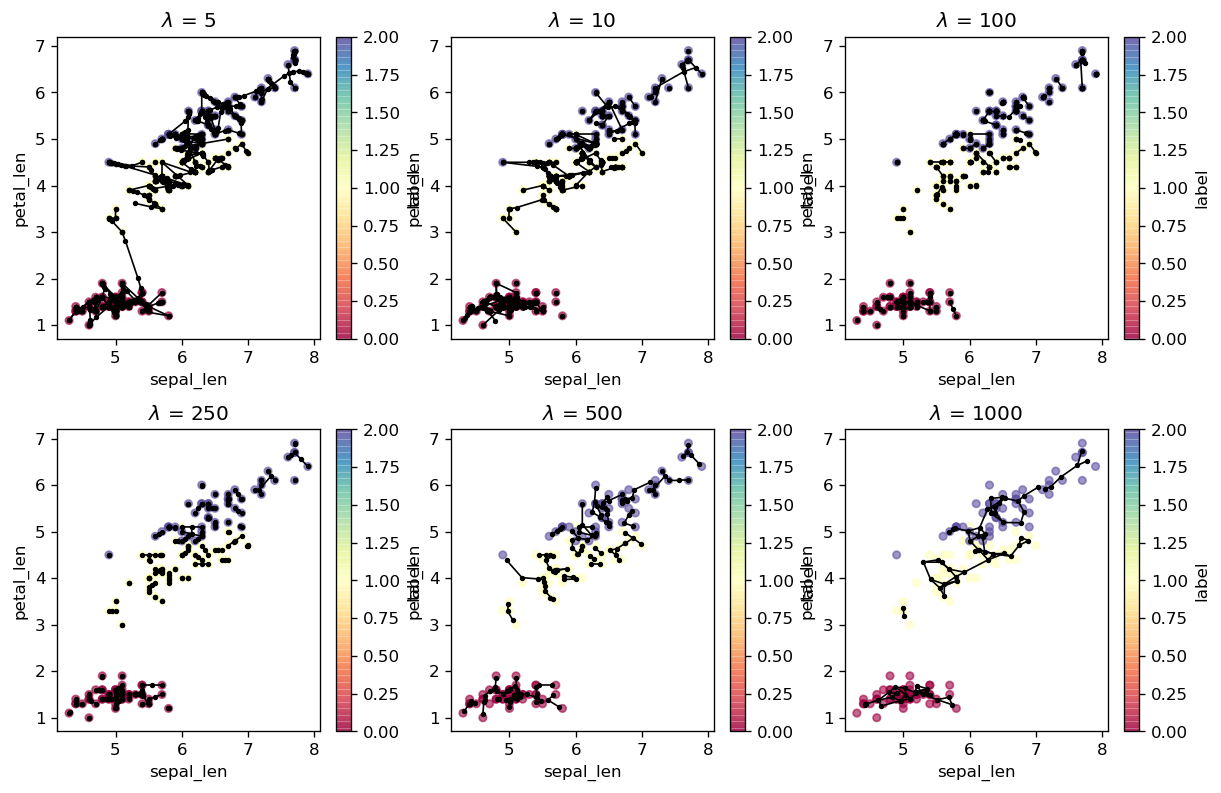

In [19]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

dims_test3 = get_2d_position(['sepal_len', 'petal_len'], feature_names)
title_names = generate_title_names("$\lambda$ = {value}", test3_n_iter_before_neuron_added)

show_gng_models(gng_models_test3, title_names, dims_test3, {
    'data': irisdf,
    'x': 'sepal_len',
    'y': 'petal_len',
    'label': 'label',
    'cmap': cmap
}, (3, 3))


O primeiro ponto notado nestes resultados é que, dado a pouca quantidade de instância presentes no conjunto de dados, nos testes em que há uma maior frequência de adição de neurônios há a relação de mais de um neurônio para cada amostra. Além disso, outro comportamento notado foi o de que, a adição excessiva fez o processo de treinamento não ter tempo de realizar ajustes, não sendo possível fazer eliminações de neurônios ou conexões pouco úteis. Este comportamento pode ser notado nos primeiros mapas, onde adições de neurônios foram feitas após `5` e `10` iterações, esses apresentam conexões que como sugeriodo pelo `Teste 1 - Quantidade máxima de neurônios`, foram gerados nos primeiros passos do processo de ajuste da topologia. Tal comportamento, pode ser explicado pela `sensibilidade` a erros que a adição de vários neurônios gera, onde mesmo erros pequenos acabam sendo preenchidos pela rede com novos neurônios.

Por outro lado, para os casos em que há tempos maiores, como ocorre para as simulações com `100` e `250` iterações, tem-se especializações maiores, onde há multiplos neurônios por instância, porém esses, isolados em grupos mais específicos, sem conexões com outros grupos. Por fim, as simulações com `500` e `1000` iterações geram comportamentos já vistos, onde o processo de treinamento busca representar os padrões dos dados com uma quantidade mínima de neurônios.

> Assim como visto nos testes anteriores, para as simulações com `500` e `1000`, tem-se a influência da quantidade de `epochs` que está sendo utilizada.


### Experimento 2 - Wine *dataset*

No experimento anterior, os principais hiperparâmetros apresentados durante a aula sobre a rede GNG e que foram requerido pelo exercício foram variados para a exploração do comportamento e primeiro contato com a interpretação dos resultados da rede. Neste segundo experimento, além dos hiperparâmetros já utilizados, outros serão considerados. Para isso, será feito o uso de um modelo `default`, seguindo as recomendações da literatura apresentado durante a aula. No modelo `default`, são utilizados os seguintes valores:

- $a_{max}$: 90
- $\lambda$: 50
- $\alpha$: 0.5
- $\beta$: 0.005
- $\eta_b$: 10^-2
- $\eta_n$: 10^-4

Para a realização deste segundo experimento será considerado o conjunto de dados Wine, disponibilizado no repositório [UCI Machine Learning](https://archive.ics.uci.edu/ml/index.php). O conjunto de dados possui 178 instâncias com 13 atributos, sendo eles:


- `Alcohol`
- `Malic acid`
- `Ash`
- `Alcalinity of ash`
- `Magnesium`
- `Total phenols`
- `Flavanoids`
- `Nonflavanoid phenols`
- `Proanthocyanins`
- `Color intensity`
- `Hue`
- `OD280/OD315 of diluted wines`
- `Proline`

Cada instância está associada a um rótulo que representa o tipo de vinho correspondente à instância.


**Importação do conjunto de dados**

Para tornar o processo de aquisição dos dados mais simples, será feito o uso da função `load_wine` presente no módulo `datasets` da biblioteca [scikit-learn](https://scikit-learn.org/stable/).


In [20]:
wine = sklearn.datasets.load_wine()

Com os dados carregados, faz-se a criação de sua representação em formato de tabela.

> Para evitar as influências, junto a geração da tabela é feito o processo de padronização estatística. Este é realizado com o auxílio da classe `StandardScaler`, presente no módulo `sklearn.preprocessing` da biblioteca [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).


In [21]:
wine_scaled = StandardScaler().fit_transform(wine.data)

winedf = pd.DataFrame(wine_scaled, columns = wine.feature_names)
winedf['label'] = wine.target

winedf.head(3)

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  label  
0         0.251717  0.362177                      1.847920  1.013009      0  
1        -0.293321  0.406051                      1.113449  0.965242      0  
2         0.269020  0.318304                      0.788587  1.395148      0

Agora é feita a visualização da relação e distribuição dos dados, da mesma forma como realizado no experimento anterior. Tal visualização auxilia nos processos de interpretação e visualização das topologias geradas.


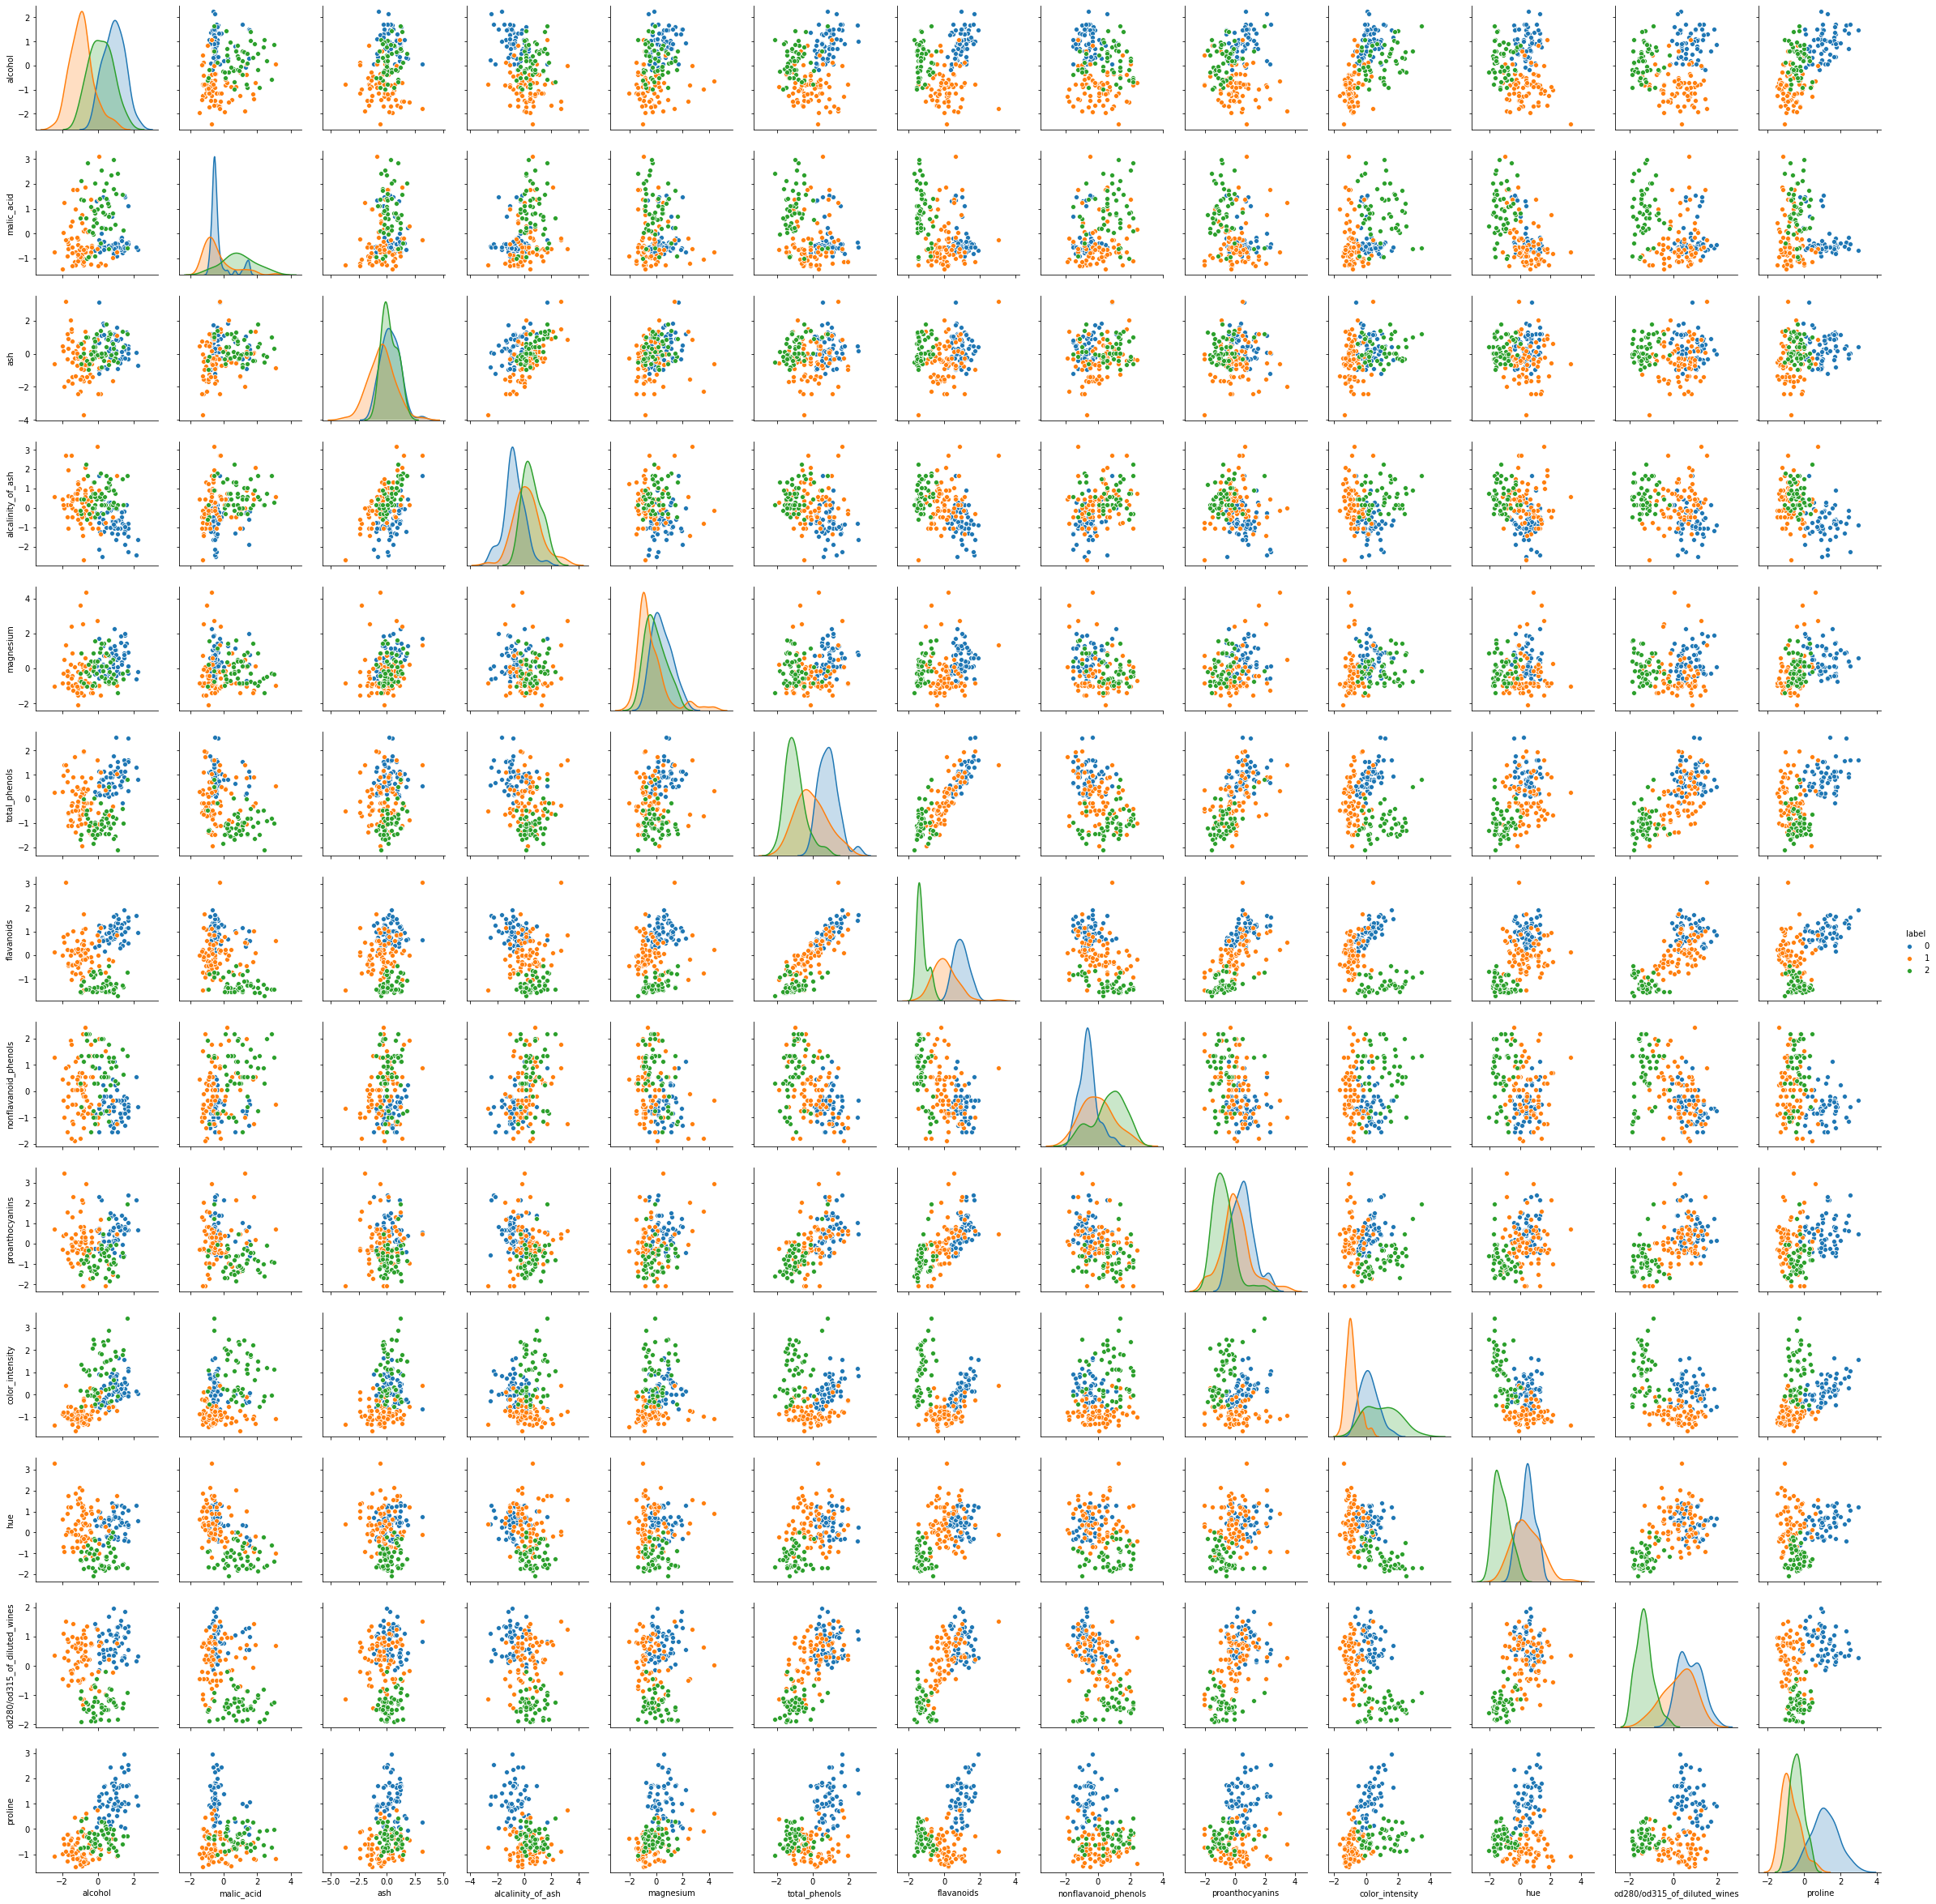

In [22]:
sns.pairplot(winedf, hue = 'label')

#### Teste 1 - Quantidade de epochs

Este primeiro teste busca entender a influência da quantidade de `epochs` aplicadas no processo de treinamento. Tal teste é inspirado nos resultados obtidos nos testes do experimento anterior. Para sua realização, será feita a declaração do modelo `default`, seguindo os parâmetros apresentados anteriormente. Em seguida, como forma de dar continuidade a exploração do impacto da quantidade de `epochs` nos resultados da GNG, iniciado no experimento anterior, será feita a variação deste parâmetro no processo de treinamento. As simunações serão realizadas com os valores de `epochs` $[10, 50, 100, 250, 500, 1000]$.

Inicialmente, faz-se a definição do modelo `default`.

> É importante notar que o valor de $\beta$, representado pela variável `error_decay_rate` está sendo inserido de uma forma diferente do valor apresentado nas notas de aula disponibilizadas pelo professor. Esta mudança está sendo feito já que, após vários testes foi identificado no [código fonte](https://github.com/itdxer/neupy/blob/04d7ff4d04f5b1839fe2ad7a42b97a2501da12d0/neupy/algorithms/competitive/growing_neural_gas.py#L413) que o valor de $E$ é definido como sendo o resultado da multiplicação do próprio $E$ com $\beta$ ($E$ = $E$ * $\beta$). Assim, ao utilizar a subtração do valor 1 com o $\beta$, tem-se equivalência entre a formula apresentada pelo professor e a maneira como o código aplica este valor.


In [23]:
model_default_test1 = algorithms.GrowingNeuralGas(
    n_inputs                     = len(wine.feature_names),  # Dimensões = Quantidade de atributos em cada instância
    n_start_nodes                = 2, 
    max_edge_age                 = 90,         # a_max 
    n_iter_before_neuron_added   = 50,         # lambda
    after_split_error_decay_rate = 0.5,        # alpha (Padrão também usado no NeuPy)
    error_decay_rate             = 1 - 0.005,  # beta
    step                         = 10**-2,     # Nb
    neighbour_step               = 10**-4      # Nn
)

Com a definição feita, os mapas são gerados variando a quantidade de `epochs`. 

> Para a realização dessa simulação, o código abaixo realiza várias cópias da variável `model_default_test1`, onde foi salvo o modelo `default` declarado, de modo que em nenhum caso seja feito o uso de um mapa já treinado.

In [24]:
epochs = [10, 50, 100, 250, 500, 1000]

# copiando o mesmo modelo na memória (Gera diferentes objetos na memória)
models_default_test_1 = [copy.deepcopy(model_default_test1) for i in range(len(epochs))]

# realizando treinamento dos modelos
[model.train(winedf.iloc[:, 0:-1], epochs = epoch) for model, epoch in zip(models_default_test_1, epochs)]

[None, None, None, None, None, None]

Como foi citado anteriormente, o modelo GNG está sendo treinado considerando todos os atributos que estão presentes no conjunto de dados, porém, para sua visualização no espaço de atributos, estão sendo consideradas apenas dois atributos. Desta forma, para a apresentação dos resultados, considerando as características de distribuição que tornam a visualização mais interessante, serão utilizados dois grupos de atributos: (I) `Proline e OD280/OD315 of diluted wines`; (II) `Flavanoids e Color intensity`.

O índice de cada uma dessas dimensões é recuperado abaixo.


In [25]:
wine_dims1 = get_2d_position(['proline', 'od280/od315_of_diluted_wines'], wine.feature_names)
wine_dims2 = get_2d_position(['flavanoids', 'color_intensity'], wine.feature_names)

**Visualizando os modelos gerados através dos atributos `Profile` e `OD280/OD315 of diluted wines`**

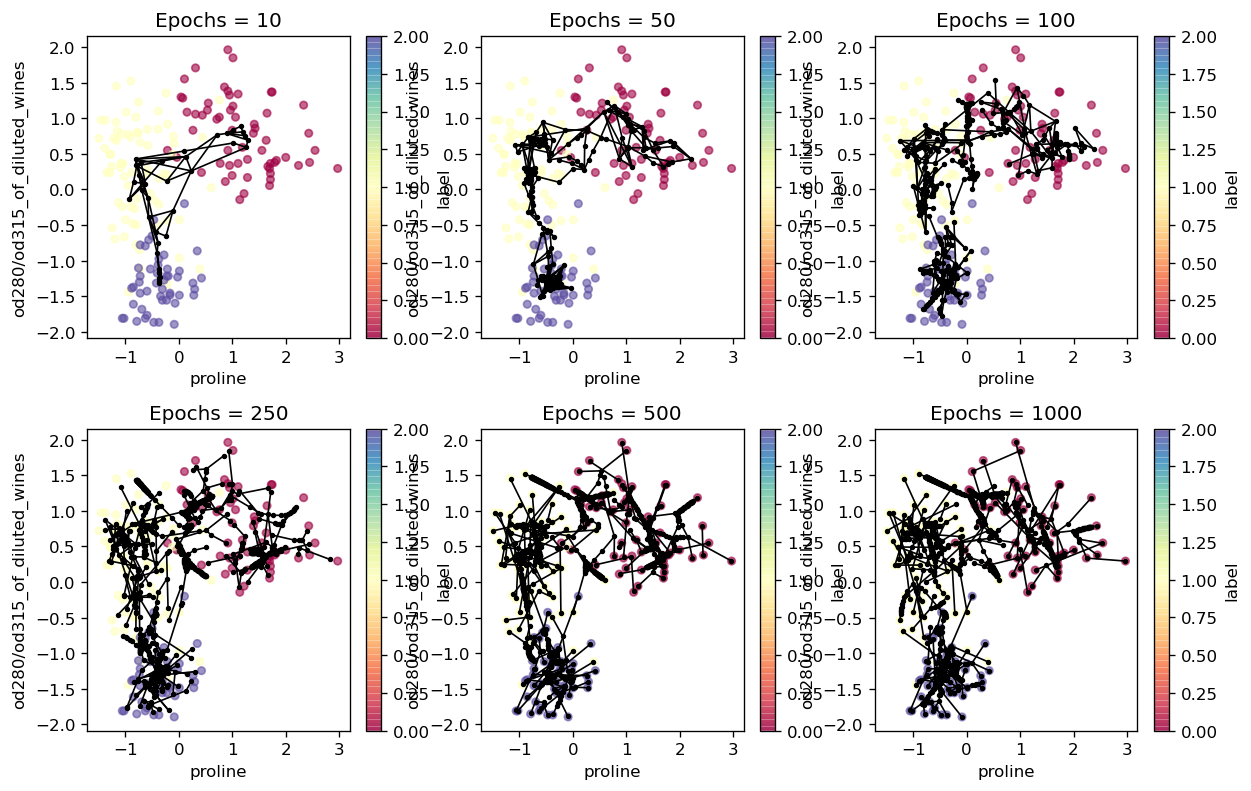

In [26]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("Epochs = {value}", epochs)

show_gng_models(models_default_test_1, title_names, wine_dims1, {
    'data': winedf,
    'x': 'proline',
    'y': 'od280/od315_of_diluted_wines',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

**Visualizando os modelos gerados através dos atributos `Flavanoids` e `Color Intensity`**

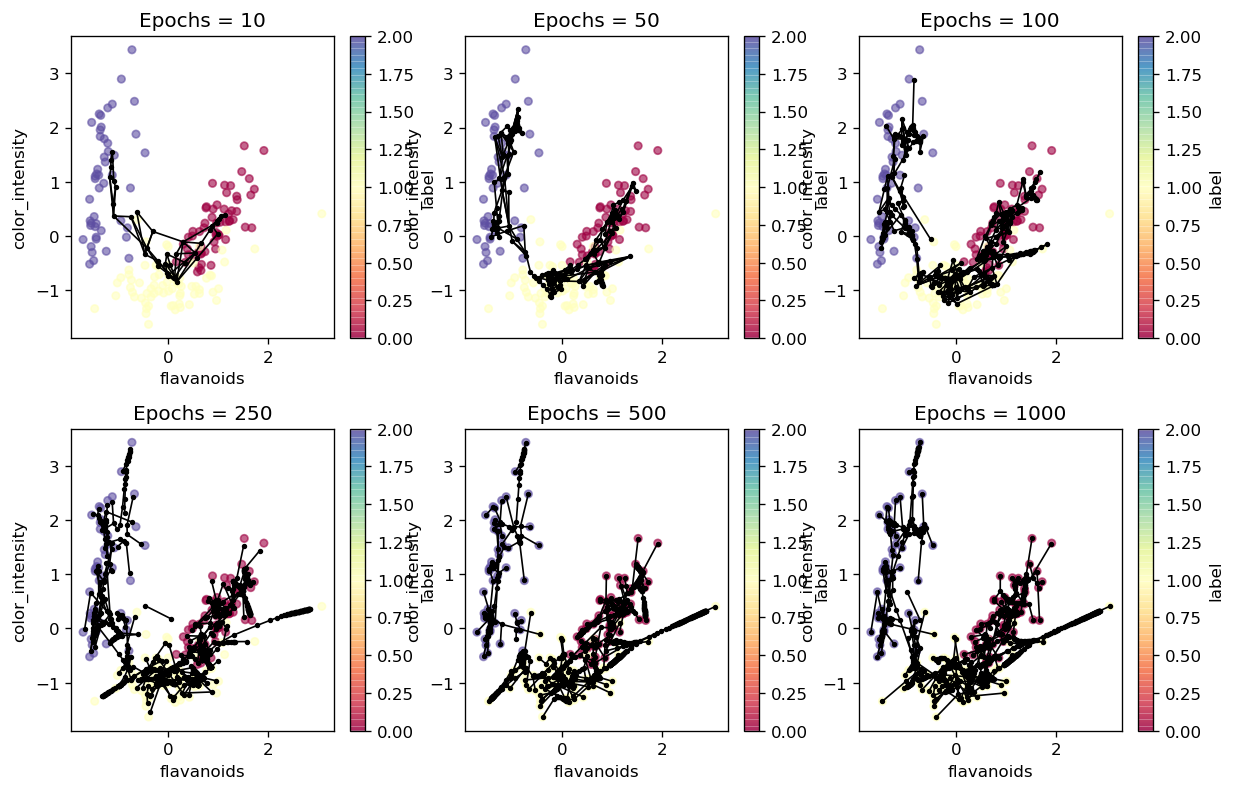

In [27]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("Epochs = {value}", epochs)
show_gng_models(models_default_test_1, title_names, wine_dims2, {
    'data': winedf,
    'x': 'flavanoids',
    'y': 'color_intensity',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Analisando as figuras, pode-se perceber que a pouca quantidade de `epochs`, assim como esperado, faz com que o mapa não tenha tempo para realizar seu desenvolvimento . Tal comportamento é visto nos mapas com `10` e `50` `epochs`. Porém, com o aumento desta quantidade, tem-se também um aumento constante da quantidade de neurônios que estão sendo adicionados. Isso pode estar sendo causado pela quantidade de neurônios possíveis, que por padrão no [NeuPy](http://neupy.com/pages/home.html) é `1000` e também pela quantidade de iterações que o modelo está considerando para fazer a adição de novos neurônios. 

Como forma de investigar tais possibilidades, abaixo, faz-se a mudança no modelo `default`, aumentando a quantidade de iterações necessárias para a adição de um novo neurônio e diminuindo a quantidade total de neurônios que pode ser inserida no mapa.

Serão utilizados $\lambda$ = 150 e Nmax = $5 * \sqrt{N}$, onde N = Quantidade de instâncias no conjunto de dados.

> A heurística aplicada para definir este valor é citada por [Shalaginov & Franke, 2015](https://link.springer.com/chapter/10.1007/978-3-319-19222-2_46), no contexto do algoritmo Self-Organizing Maps. Como forma de teste, esta será aplicada no contexto de uso do GNG.


In [28]:
model_default_test1_modified = algorithms.GrowingNeuralGas(
    n_inputs                     = len(wine.feature_names),  # dimensões
    n_start_nodes                = 2, 
    max_nodes                    = int(5 * sqrt(winedf.shape[0])),
    max_edge_age                 = 90,         # a_max 
    n_iter_before_neuron_added   = 150,        # lambda
    after_split_error_decay_rate = 0.5,        # alpha (Padrão também usado no NeuPy)
    error_decay_rate             = 1 - 0.005,  # beta
    step                         = 10**-2,     # Nb
    neighbour_step               = 10**-4      # Nn
)

Com as alterações declaradas no modelo acima, faz-se o treinamento utilizando o mesmo conjunto de `epochs` definido anteriormente.

In [29]:
models_default_modified_test_1 = [copy.deepcopy(model_default_test1_modified) for i in range(len(epochs))]
[model.train(winedf.iloc[:, 0:-1], epochs = epoch) for model, epoch in zip(models_default_modified_test_1, epochs)]

[None, None, None, None, None, None]

A visualização do resultado é apresentada abaixo. Por uma questão de simplicidade, os resultados serão apresentados considerando apenas as dimensões `proline` e `od280/od315_of_diluted_wines`.

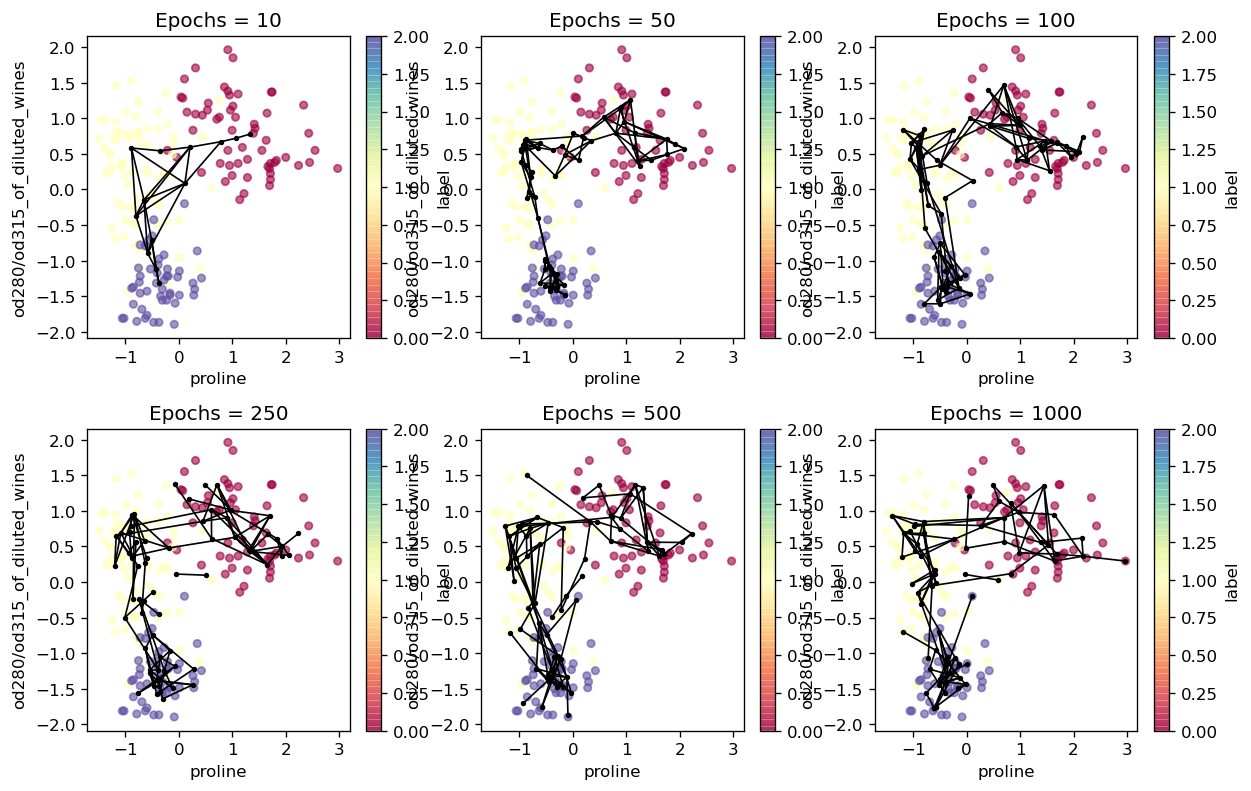

In [30]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("Epochs = {value}", epochs)
show_gng_models(models_default_modified_test_1, title_names, wine_dims1, {
    'data': winedf,
    'x': 'proline',
    'y': 'od280/od315_of_diluted_wines',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Agora, de uma maneira mais clara é possível perceber as mudanças que estão sendo realizadas ao aumentar a quantidade de `epochs`. Neste novo resultado nota-se a distribuição do mapa sendo realizada entre as três classes de elementos que está presente no espaço de atributos. Por exemplo, veja que o mapa gerado com 250 `epochs` possui muito mais conexões entre neurônios que estão sendo utilizados para representar classes diferentes (Neurônios dos elementos `Roxo` e `Amarelo`), porém, com a evolução apresentada pelo mapa de 500 e 1000 `epochs`, nota-se a separação de tais elementos e a redução de conexão entre eles.

Além disso, cabe notar que para quantidades `10` e `50` `epochs`, tem-se um aglomerado de neurônios sendo gerados. Tal comportamento também pode ser visto no teste anterior e pode estar vinculado a pouca quantidade de tempo que o algoritmo de treinamento teve para realizar os ajustes dos elementos do mapa.

#### Teste 2 - Variação do valor de $\beta$

"O decaimento (Gerado com a aplicação do $\beta$) em cada neurônio, ajuda a esquecer os neurônios que já não serve para nada" - Marcos Quiles (23/11/2020) 

Como apresentado durante as aulas, o hiperparâmetro $\beta$ é utilizado para a redução do erro acumulado de cada neurônio presente no mapa. Sua aplicação no processo de treinamento ajuda a inibir neurônios que não ganham mais competições, o que ocorre por esses representarem áreas que não possuem mais instâncias de dados associadas. Assim, mesmo o neurônio tendo um erro associado, com o tempo, este será reduzido a zero, evitando que outros neurônios sejam adicionados em regiões que não possuem mais instâncias associadas.

Considerando a importância deste hiperparâmetro, este teste verifica seu impacto nos resultados gerados pela rede GNG. Para isso, será feito o uso do modelo `default` modificado no `Teste 1 - Quantidade de epochs` ($\lambda$ = 150 e Nmax = $5 * \sqrt{N}$), variando neste o $\beta$ com os seguintes valores: $[0.005, 0.015, 0.1, 0.5, 0.7, 1]$.

> O modelo `default` modificado será utilizado já que, ao fazer testes com o modelo considerando os parâmetros padrão, foi identificado o mesmo problema visto no `Teste 1 - Quantidade de epochs`, onde muitos neurônios foram inseridos o que tornou complexa a interpretação dos resultados.

Para começar, abaixo é feita a declaração de cada um dos modelos, variando o valor de $\beta$ de cada um deles.

In [31]:
betas = [0.0001, 0.005, 0.015, 0.1, 0.5, 0.7]

In [32]:
models_default_test2 = [algorithms.GrowingNeuralGas(
    n_inputs                     = len(wine.feature_names),  # dimensões
    n_start_nodes                = 2, 
    max_nodes                    = int(5 * sqrt(winedf.shape[0])),
    max_edge_age                 = 90,         # a_max 
    n_iter_before_neuron_added   = 150,        # lambda
    after_split_error_decay_rate = 0.5,        # alpha (Padrão também usado no NeuPy)
    error_decay_rate             = (1 - beta), # beta
    step                         = 10**-2,     # Nb
    neighbour_step               = 10**-4      # Nn
) for beta in betas]

Agora, é feito o processo de treinamento de cada um deles considerando 1000 `epochs`.

In [33]:
[model.train(winedf.iloc[:, 0:-1], epochs = 1000) for model in models_default_test2]

[None, None, None, None, None, None]

A visualização dos mapas gerados é apresentada abaixo, esta será feita utilizando os dois grupos de atributos especificados anteriormente.

**Visualizando os modelos gerados através dos atributos `Profile` e `OD280/OD315 of diluted wines`**

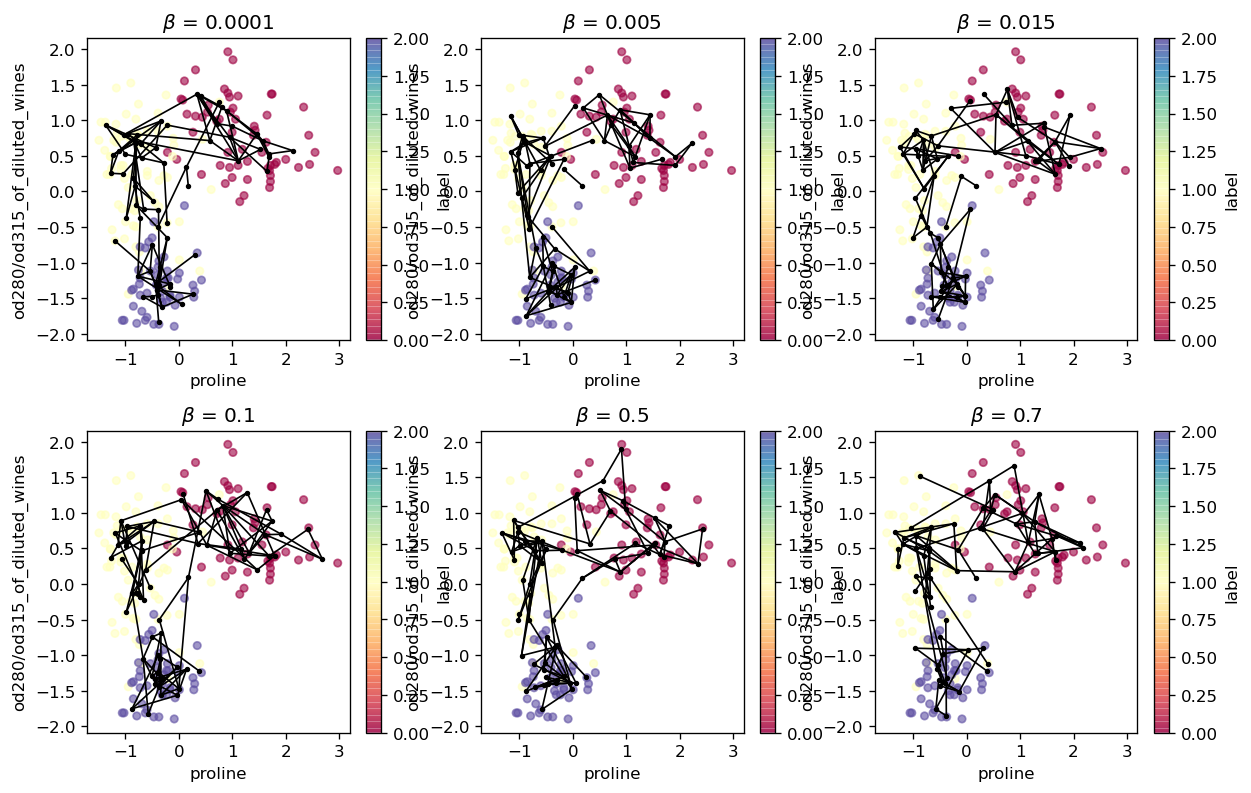

In [34]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("$\\beta$ = {value}", betas)
show_gng_models(models_default_test2, title_names, wine_dims1, {
    'data': winedf,
    'x': 'proline',
    'y': 'od280/od315_of_diluted_wines',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

**Visualizando os modelos gerados através dos atributos `Flavanoids` e `Color Intensity`**

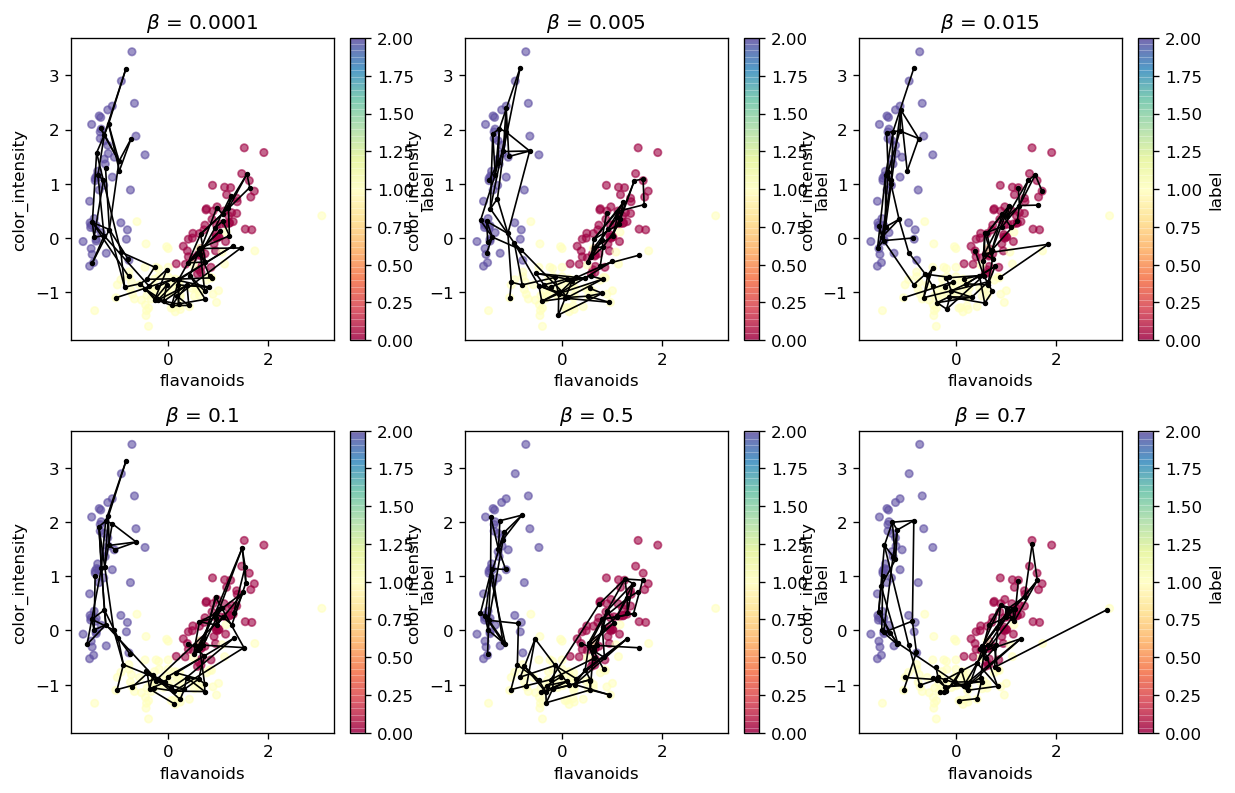

In [35]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("$\\beta$ = {value}", betas)
show_gng_models(models_default_test2, title_names, wine_dims2, {
    'data': winedf,
    'x': 'flavanoids',
    'y': 'color_intensity',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

De maneira geral, ao realizar a análise dos mapas resultantes das simulações nos pares de dimensão selecionados, pode-se perceber que o uso de valores de $\beta$ pequenos (`0.0001`, `0.005`, `0.015` e `0.1`), acabou levando a adição de mais neurônios no mapa para regiões em que houveram poucas ativações. Por exemplo, ao avaliar o mapa com as dimensões `Flavonoids` e `Color Intensity`, nota-se que há neurônios presentes nas regiões roxas com poucas ativações, o que, quando considerado nos mapas gerados com valores maiores de $\beta$ (`0.5` e `0.7`), não foram apresentados.

> Avaliando estes resultados, pode-se confirmar o que foi visto em aula, onde, para valores menores, tem-se uma menor diminuição da influência de erros presentes em neurônios vencem pouco, fazendo com que o algoritmo de treinamento gere mais neurônios em certas regiões para reduzir os erros.

> Para a geração dos resultados apresentados neste documento, diversas execuções foram feitas, todas apresentando resultados similares aos apresentados nos resultados acima, porém, deve ser notado que, há a influência da quantidade de `epochs` que estão sendo utilizadas.

Para fechar este teste, fez-se o uso do visualizador [DemoGNG.js](https://www.demogng.de/js/demogng.html?_3DV), porém, pode-se perceber que o $\beta$, para o contexto do aplicativo, só é aplicado quando o fator de utilidade está ativo, elemento o qual não está disponível no [NeuPy](http://neupy.com/pages/home.html), biblioteca utilizada para implementar os testes desta lista de exercícios.


### Experimento 3 - Wine Quality *dataset* (Red Wine)

Até este ponto, os experimentos e testes que foram realizados, consideraram conjuntos de dados com uma pequena quantidade de instâncias. Desta forma, este experimento, que busca variar outros parâmetros além dos já apresentados, será feito com o conjunto de dados [Wine Quality](https://archive.ics.uci.edu/ml/datasets/Wine+Quality), disponibilizado no repositório [UCI Machine Learning](https://archive.ics.uci.edu/ml/index.php). No repositório estão presentes dois conjuntos de dados, o conjunto para qualidade do vinho branco e outro do vinho vermelho. Para este contexto, será feito o uso dos dados do vinho vermelho, que possui 1599 instâncias com 11 atributos, sendo eles:

- `Fixed acidity`
- `Volatile acidity`
- `Citric acid`
- `Residual sugar`
- `Chlorides`
- `Free sulfur dioxide`
- `Total sulfur dioxide`
- `Density`
- `pH`
- `Sulphates`
- `Alcohol`

Para cada instância, há também um atributo de qualidade, que varia de 0 à 10. Da mesma forma como feito no testes anteriores, este valor será utilizado para auxiliar a interpretação dos mapas que estão sendo gerados.

Seguindo o processo feito no `Experimento 2 - Wine dataset`, os testes e variação de parâmetros serão feitos com base no modelo `default`, que segue os hiperparâmetros encontrados na literatura que foram apresentados nas notas de aula. Os valores dos hiperparâmetros deste modelo são os seguintes:

- $a_{max}$: 90
- $\lambda$: 50
- $\alpha$: 0.5
- $\beta$: 0.005
- $\eta_b$: 10^-2
- $\eta_n$: 10^-4


**Importação do conjunto de dados**

Diferente dos experimentos anteriores, não há no [scikit-learn](https://scikit-learn.org/) uma funcionalidade que facilite a importação do conjunto de dados selecionado. Desta forma, para a importação dos dados será feito o uso da biblioteca [Pandas](https://pandas.pydata.org/), esta permite que arquivos sejam carregados diretamente de servidores *web*. Considerando isso, faz-se a importação direta dos dados que estão disponíveis no repositório UCI.

> A importação foi feita utilizando a função `read_csv`, presente no módulo `io.parsers`, da biblioteca [Pandas](https://pandas.pydata.org/).


In [36]:
wine_qualitydf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ";")

wine_qualitydf.head(3)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5

Com o objetivo de entender a relação e distribuição dos dados, faz-se o uso da função `pairplot`, disponível na biblioteca [Seaborn](https://seaborn.pydata.org/), como visto nos experimentos anteriores.

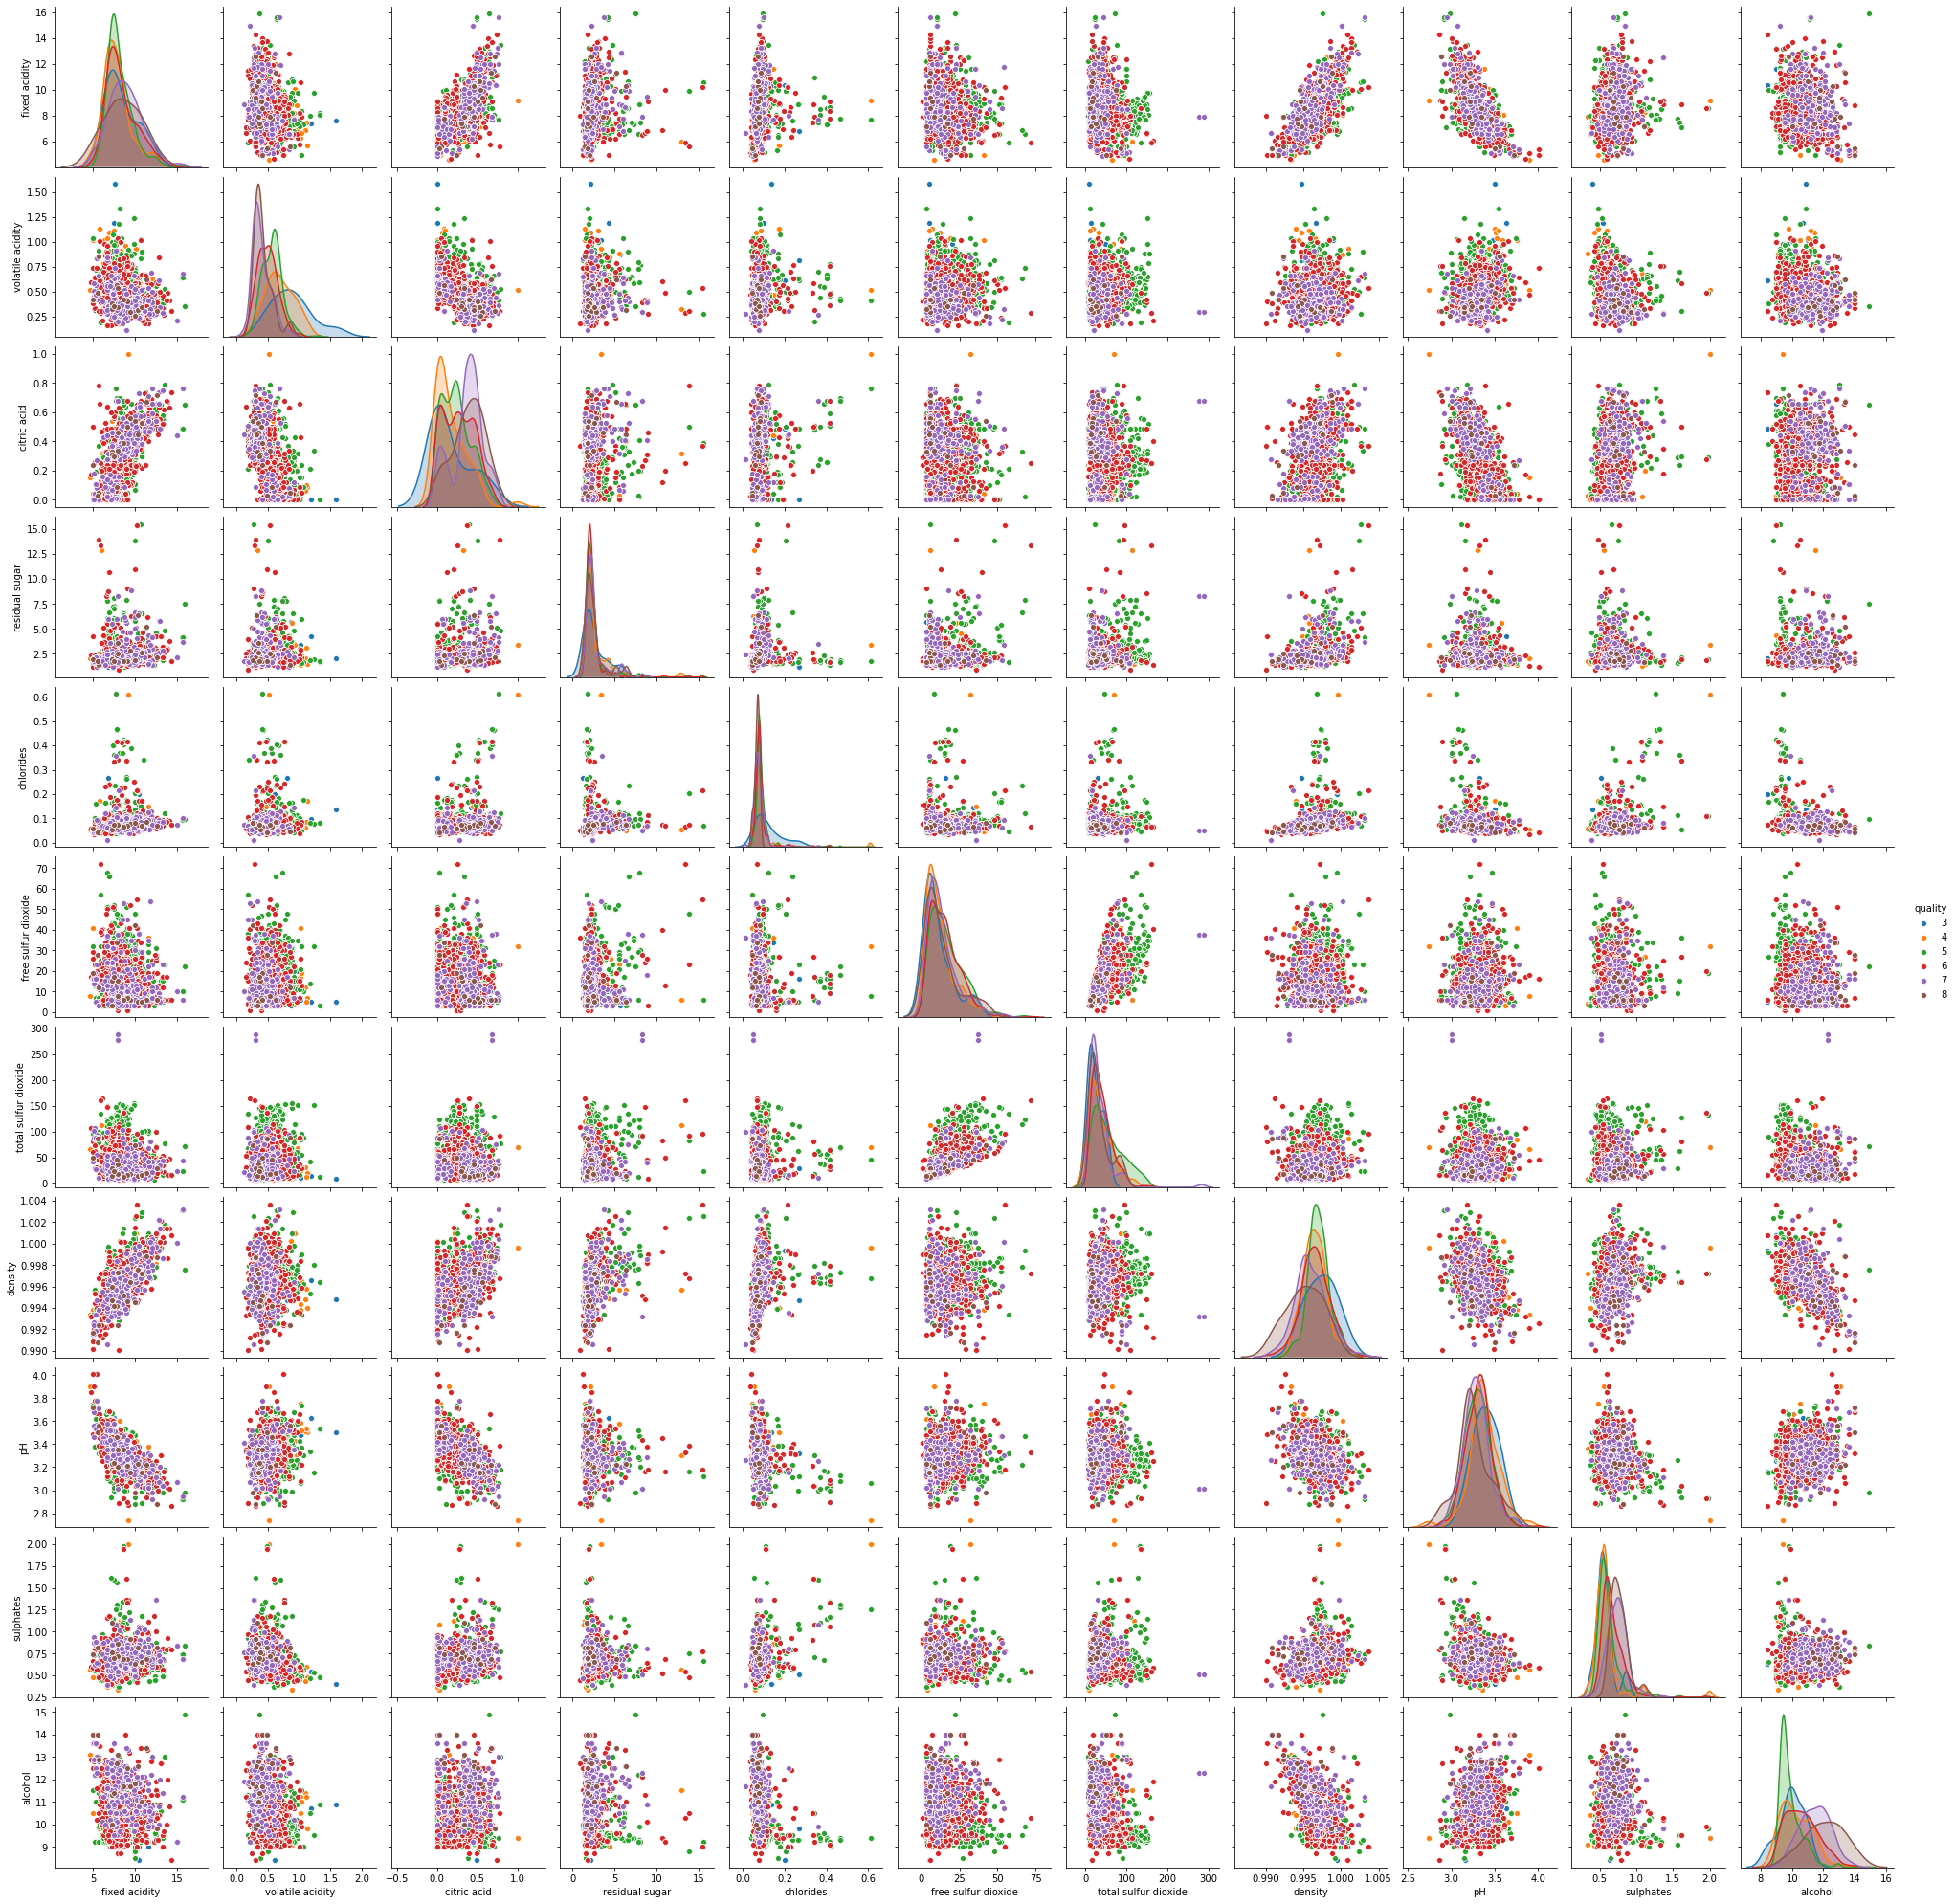

In [37]:
sns.pairplot(wine_qualitydf, hue = 'quality')

Como pode ser observado por conta da baixa granularidade do atributo de qualidade (`quality`), que varia de 0 à 10, tem-se uma grande mistura das informações. Para simplificar os elementos do conjunto de dados de modo a tornar mais simples a interpretação das visualizações, é feita a conversão dessas informações de qualidade em uma estrutura binária, onde o vinho pode ter qualidade `Boa` ou `Ruim`.

Para isso, será utilizado como limiar o valor `7`, onde elementos iguais ou maiores a este serão ditos com qualidade `Boa` e abaixo qualidade `Ruim`.

> A aplicação desta transformação acaba generalizando as informações do conjunto de daods, porém, como o processo está sendo feito no contexto não supervisionado, o impacto estará presente apenas nas visualizações.

Abaixo é feita a geração dessas informações. Os resultados são inseridos em uma coluna nomeada `label` da tabela de dados e o atributo de qualidade (`quality`) é removido.

> No resulado gerado, faz-se o uso de valores discretos, onde `1` representa a qualidade `Boa` e `0` a qualidade `Ruim`.


In [38]:
# 0 = Ruim
# 1 = Boa
wine_qualitydf['label'] = [1 if x >= 7 else 0 for x in wine_qualitydf['quality']]

# deletando o atributo (coluna) de qualidade
del wine_qualitydf['quality']

Com a transformação realizada, é feita agora a visualização das distribuições e relações presentes no conjunto de dados.

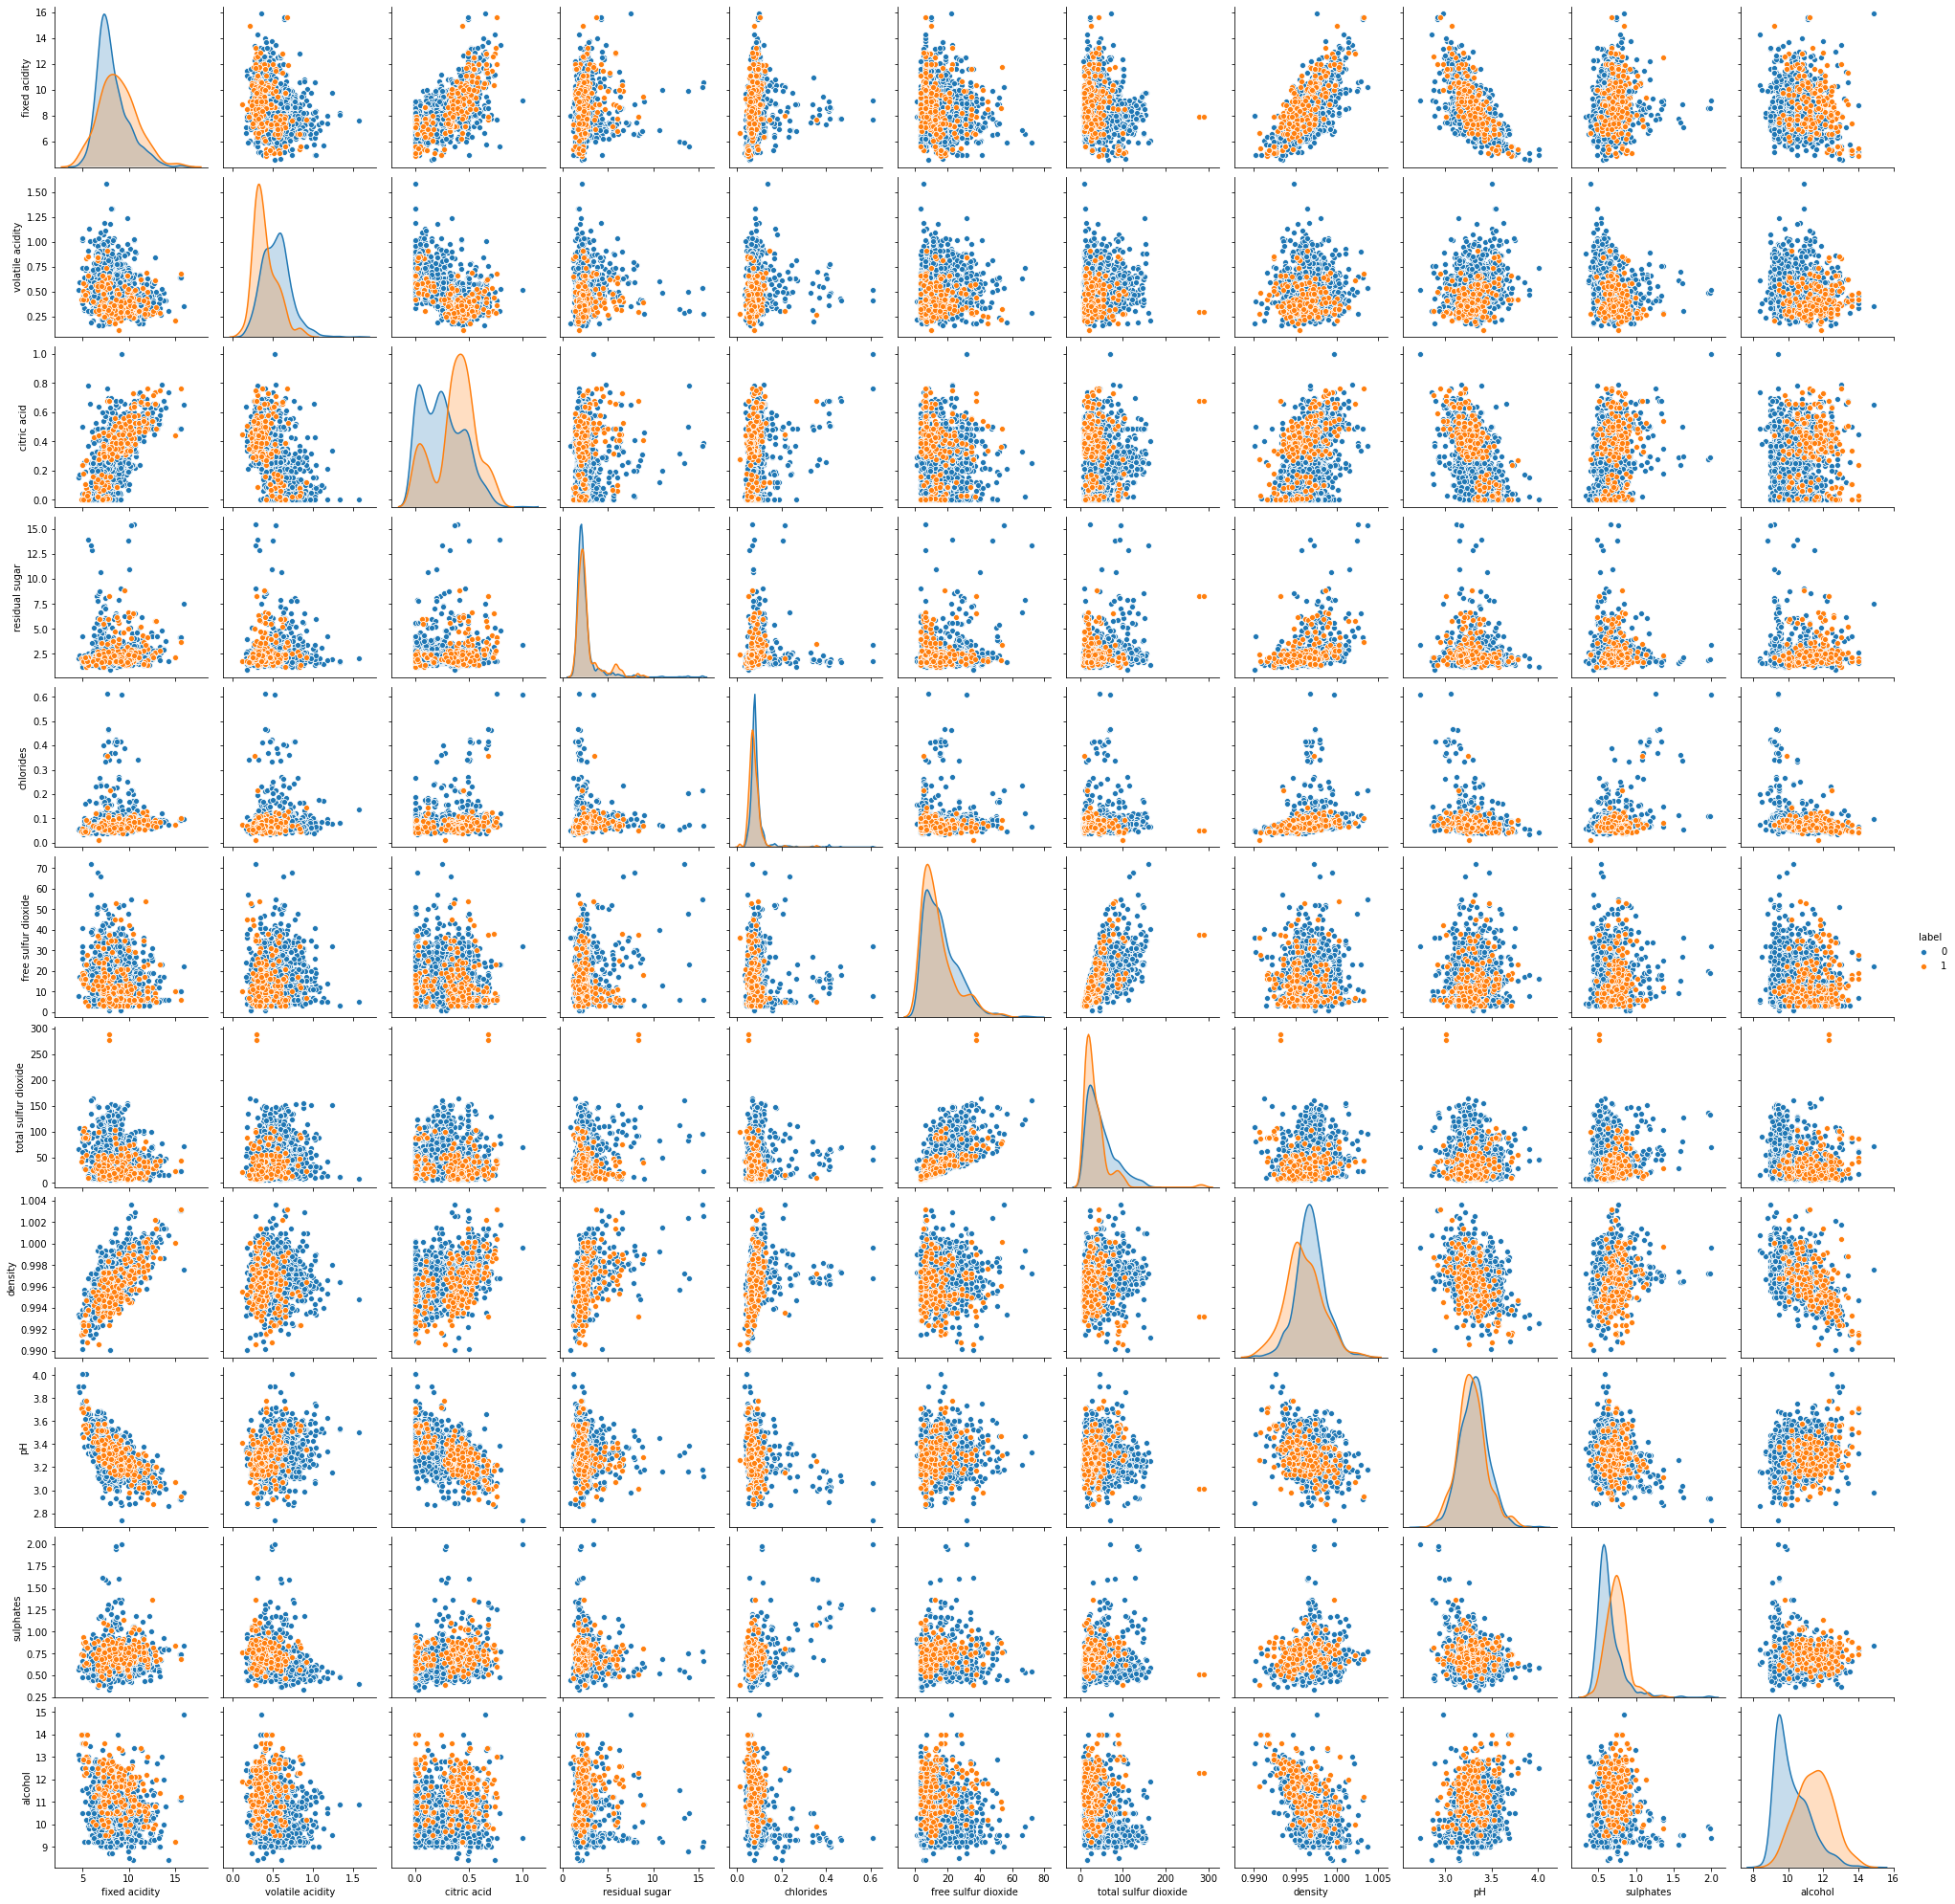

In [39]:
sns.pairplot(wine_qualitydf, hue = 'label')

Note que nenhuma transformação foi realizada nos dados, porém, a sumarização das informações de qualidade nas classes `Boa` ou `Ruim` facilitaram o processo de entendimento das relações presentes no conjunto de dados. Antes de iniciar os testes, como há diversos atributos no conjunto de dados, será feito a padronização estatística dos dados, de modo a evita a influência de tais valores no processo de treinamento.

> A aplicação da padronização estatística é feita com o auxílio da classe `StandardScaler`, presente no módulo `sklearn.preprocessing`, da biblioteca [scikit-learn](https://scikit-learn.org/stable/).


In [40]:
wine_qualitydf_scaled = StandardScaler().fit_transform(wine_qualitydf.iloc[:, 0:-1])

# Organizando os dados e um DataFrame 
wine_qualitydf_scaled_df = pd.DataFrame(wine_qualitydf_scaled)
wine_qualitydf_scaled_df["label"] = wine_qualitydf["label"].values

# Alterando as colunas
wine_qualitydf_scaled_df.columns = wine_qualitydf.columns
wine_qualitydf_scaled_df.head(4)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   

    alcohol  label  
0 -0.960246      0  
1 -0.584777      0  
2 -0.584777      0  
3 -0.584777      0

#### Teste 1 - Influência da ordem dos dados

Para este primeiro teste será verificado o grau de influência que a ordem de apresentação dos dados no processo de treinamento tem nos mapas gerados. A ideia deste teste é utilizar da informação prévia que se tem sobre os dados, neste caso representado pelas informações sumarizadas nos grupos de qualidade `Boa` e `Ruim`, para verificar se a apresentação de um grupo após o outro influencia o mapa final gerado.

Desta forma serão feitos duas simulações principais. Na primeira delas, faz-se a ordenação do conjunto de dados considerando a qualidade (`Boa` ou `Ruim`), de modo que todas as instâncias do grupo `Ruim ` fiquem dispostas antes dos elementos do grupo de qualidade `Boa`. Já no segundo teste, será feito o embaralhamento dos dados, de modo que as instâncias sejam apresentadas em ordem aleatória.

> A execução deste teste foi feita diversas vezes, o que resultou na mudança dos parâmetros `max_nodes` e `max_edge_age`. Tais parâmetros foram variados buscando gerar um equilíbrio entre a quantidade de neurônio que estava sendo adicionado e suas conexões com o total de neurônios na rede. Ao final deste processo fez-se a escolha dos valores `20` e `100`, para `max_nodes` e `max_edge_age`, respectivamente. Como o processo foi iterativo com várias execuções, eles não foram mantidos neste documento para diminuir o tempo total de execução dos experimentos.

> Além disso, por uma questão de praticidade as simulações utilizam apenas 1000 `epochs`, o que para a quantidade de dados pode ser insuficiente para o ajuste completo, porém, pelas proprias características dos dados, ao aumentar o número de `epochs`, há uma crescente muito grande no tempo de execução.

> Cabe notar também que todas as visualizações foram feitas utilizando os atributos `Total Sulfur Dioxie` e `Density`, selecionados através da avaliação do `pairplot` apresentado anteriormente

Abaixo, cada uma das simulações geradas são apresentadas.

**Simulação com dados ordenados**

Como citado, para esta primeira simulação será feito o ordenação dos dados, de modo que todos os elementos com `label` `Ruim` sejam apresentados antes dos elementos com `label` `Boa`. Para começar, os dados são ordenados.

In [41]:
wine_qualitydf_scaled_df_sorted = wine_qualitydf_scaled_df.sort_values(by = "label")

Como uma forma de validação é feita a visualização dos elementos presentes no vetor de `labels`, de modo a garantir que todos os zeros (grupo `Ruim`) estejam dispostos antes dos elementos um (grupo `Boa`).

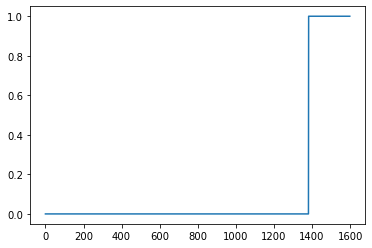

In [42]:
plt.plot(wine_qualitydf_scaled_df_sorted["label"].values)

Acima é possível perceber que os elementos como `0` são apresentados antes que os elementos marcados como `1`.

> Uma coisa interessante que pode ser notada com esta visualização é a quantidade desbalanceada de elementos em cada classe, o que como visto em aula e testado no [DemoGNG.js](https://www.demogng.de/js/demogng.html?_3DV), pode influênciar o mapa que está sendo gerado.

Com os dados ordenados, faz-se a definição do modelo `default` seguindo as mudanças apresentadas no teste anterior e então faz-se a geração do mapa.


In [43]:
model_default_test1_exp3_without_shuffle = algorithms.GrowingNeuralGas(
    n_inputs                     = wine_qualitydf_scaled_df_sorted.shape[1] - 1,  # dimensões = quantidade de atributos - 1 (`label` é desconsiderado)
    shuffle_data                 = False,       # Evita que os dados sejam embaralhados (Padrão = True)
    max_nodes                    = 20,
    max_edge_age                 = 100,         # a_max 
    n_iter_before_neuron_added   = 150,         # lambda
    after_split_error_decay_rate = 0.5,         # alpha
    error_decay_rate             = 1 - 0.005,   # beta
    step                         = 10**-2,      # Nb
    neighbour_step               = 10**-4       # Nn
)

model_default_test1_exp3_without_shuffle.train(wine_qualitydf_scaled_df_sorted.iloc[:, 0:-1], epochs = 1000)

Abaixo é feita a visualização do mapa gerado.

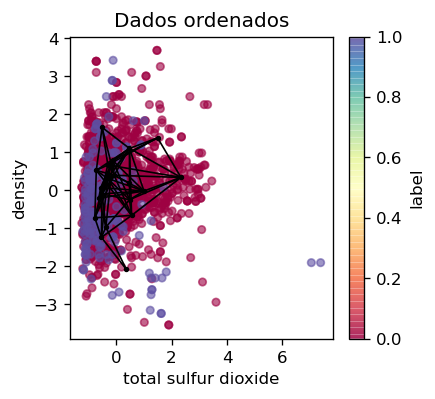

In [44]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

dims_test1_exp3 = get_2d_position(['total sulfur dioxide', 'density'], list(wine_qualitydf_scaled_df_sorted.columns))
show_gng_models([model_default_test1_exp3_without_shuffle], ["Dados ordenados"], dims_test1_exp3, {
    'data': wine_qualitydf_scaled_df_sorted,
    'x': 'total sulfur dioxide',
    'y': 'density',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

**Simulação com dados embaralhados**

Nesta segunda simulação, os dados são consumidos em uma ordem aleatória pelo algoritmo de aprendizado. Para realizar esta atividade, diferente do que foi realizado no teste anterior, onde teve-se de modificar os dados, aqui, será feito o uso do parâmetro `shuffle_data`, presente na classe `neupy.algorithms.GrowingNeuralGas` do [NeuPy](http://neupy.com/pages/home.html). Com o uso desse parâmetro, os dados são embaralhados automaticamente antes de serem utilizados no processo de treinamento.

> O valor padrão para o parâmetro `shuffle_data` é `True`, o que indica que todos os testes feitos nos experimentos anteriores contaram com o embaralhamento dos dados.

Abaixo, o modelo `default` é definido e o mapa é gerado.

In [45]:
model_default_test1_exp3_with_shuffle = algorithms.GrowingNeuralGas(
    n_inputs                     = wine_qualitydf_scaled_df.shape[1] - 1, # dimensões = quantidade de atributos - 1 (`label` é desconsiderado)
    shuffle_data                 = True,       # Evita que os dados sejam embaralhados (Padrão = True)
    max_nodes                    = 20,
    max_edge_age                 = 100,         # a_max 
    n_iter_before_neuron_added   = 150,         # lambda
    after_split_error_decay_rate = 0.5,         # alpha
    error_decay_rate             = 1 - 0.005,   # beta
    step                         = 10**-2,      # Nb
    neighbour_step               = 10**-4       # Nn
)

model_default_test1_exp3_with_shuffle.train(wine_qualitydf_scaled_df.iloc[:, 0:-1], epochs = 1000)

Abaixo é feita a visualização do mapa gerado.

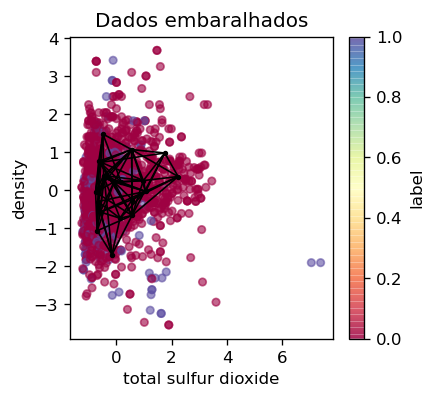

In [46]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

dims_test1_exp3 = get_2d_position(['total sulfur dioxide', 'density'], list(wine_qualitydf_scaled_df.columns))
show_gng_models([model_default_test1_exp3_with_shuffle], ["Dados embaralhados"], dims_test1_exp3, {
    'data': wine_qualitydf_scaled_df,
    'x': 'total sulfur dioxide',
    'y': 'density',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Com o processo de definição dos parâmetros `max_nodes` e `max_edge_age`, junto a avaliação dos resultados apresentados acima, nota-se que, para o conjunto de dados utilizados, não se teve grandes variações ao apresentar os dados de diferentes formas no processo de treinamento.

> Vale notar que a quantidade de `epochs` pode estar influenciando o resultado.

#### Teste 2 - Variação do valor do *learning rate* (LR) do neurônio vencedor ($\eta_b$) e da vizinhança ($\eta_n$)

Para este último teste do experimento 3, será realizada a variação do `learning rate` do neurônio vencedor ($\eta_b$) e também de sua vizinhança ($\eta_n$). O principal objetivo deste teste é o de verificar o comportamento causado no mapas após o variação desses parâmetros.

> Para evitar problemas já identificados no teste anterior, será feito o uso do modelo `default` seguindo as mesmas mudanças apresentadas no `Teste 1 - Influência da ordem dos dados`

A realização deste teste será dividida em duas partes. Na primeira delas, serão feitas simulações considerando a variação de $\eta_b$, enquanto na segunda parte são consideradas variações em $\eta_n$. Esta divisão foi feita para que a intepretação pudesse ser realizada de maneira mais fácil.

Cada uma dessas partes são apresentadas nas simulações abaixo.


**Simulação com variação $\eta_b$**

Para esta primeira simulação, será feita a variação do $\eta_b$, considerando os valores $[10^{-3}, 10^{-2}, 10^{-1}]$. 

> O parâmetro $\eta_b$ é definido na classe `neupy.algorithms.GrowingNeuralGas` através do parâmetro `steps`. Assim, os modelos gerados para a simulação farão a variação de tal parâmetro. Por padrão, seu valor é `0.2`.

> Para este experimento, o valor de $\eta_n$ utilizado será o do modelo `default`, $10^{-4}$.

Para começar, faz-se a definição dos modelos com a mudança de `steps` seguindo os valores definidos anteriormente.

In [47]:
steps = [10**-3, 10**-2, 10**-1]

models_default_test2_exp3 = [algorithms.GrowingNeuralGas(
    n_inputs                     = wine_qualitydf_scaled_df.shape[1] - 1,
    max_nodes                    = 20,
    max_edge_age                 = 100,         # a_max 
    n_iter_before_neuron_added   = 150,         # lambda
    after_split_error_decay_rate = 0.5,         # alpha
    error_decay_rate             = 1 - 0.005,   # beta
    step                         = step,        # Nb
    neighbour_step               = 10**-4       # Nn
) for step in steps]

Com os modelos criados, cada um deles são treinados com 1000 `epochs`.

In [48]:
[model.train(wine_qualitydf_scaled_df.iloc[:, 0:-1], epochs = 1000) for model in models_default_test2_exp3]

[None, None, None]

Os mapas gerados são apresentados abaixo.

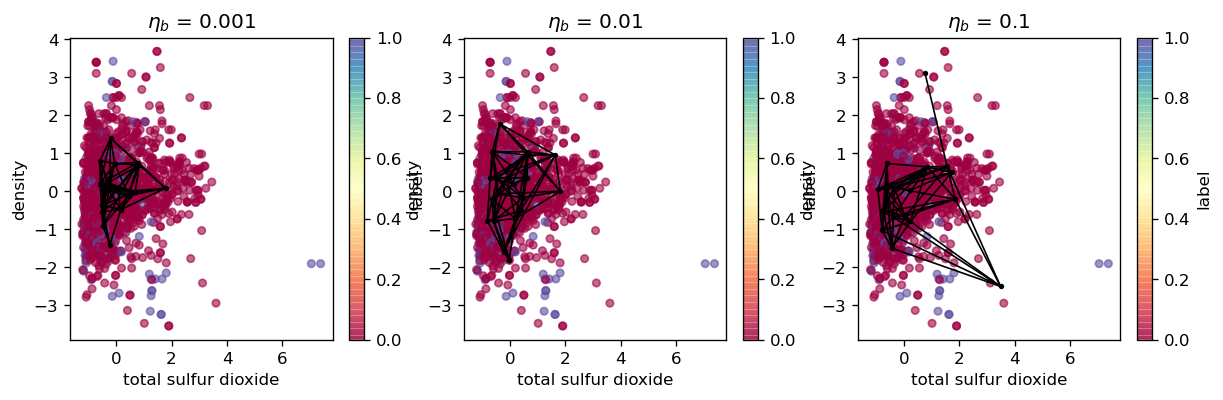

In [49]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("$\eta_b$ = {value}", steps)
dims_test2_exp3 = get_2d_position(['total sulfur dioxide', 'density'], list(wine_qualitydf_scaled_df.columns))
show_gng_models(models_default_test2_exp3, title_names, dims_test1_exp3, {
    'data': wine_qualitydf_scaled_df,
    'x': 'total sulfur dioxide',
    'y': 'density',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Com o resultado gerado é possível considerar que, pequenas quantidades de $\eta_b$, assim como esperado, geram comportamentos mais acentuados, enquanto seu aumento acaba gerando uma maior dinâmica na disposição dos neurônios. Por exemplo, nos resultados gerados, para o mapa criado com $\eta_b$ igual a `0.001`, tem-se um comportamento "mais fechado", onde os neurônios presentes na topologia estão muito próximos uns dos outros. Por outro lado, ao considerar o crescimento do valor de $\eta_b$, para a mesma quantidade de `epochs`, tem-se topologias "mais abertas", onde os neurônios estão mais espalhados sobre a superficie de atributos que está sendo considerada.

> Note que, a mudança da quantidade de `epochs` para valores menores de $\eta_b$ é fundamental. Nas simulações realizadas, o mesmo valor de `epochs` foi mantido como forma de entender justamente a influência de tal hiperparâmetro no processo de formação da topologia.


**Simulação com variação $\eta_n$**


Para esta segunda simulação, será feita a variação do $\eta_n$, considerando os valores $[10^{-4}, 10^{-3}, 10^{-2}]$. 

> O parâmetro $\eta_n$ é definido na classe `neupy.algorithms.GrowingNeuralGas` através do parâmetro `neighbour_step`. Assim, os modelos gerados para a simulação farão a variação de tal parâmetro. Por padrão, seu valor é menor que  $\eta_b$ sendo definido como `0.05`.

> Para este experimento, o valor de $\eta_b$ utilizado será o do modelo `default`, $10^{-2}$.

Para começar, faz-se a definição dos modelos com a mudança de `neighbour_step` seguindo os valores definidos anteriormente.


In [50]:
steps_neighbour = [10**-4, 10**-3, 10**-2]

models_neighbour_default_test2_exp3 = [algorithms.GrowingNeuralGas(
    n_inputs                     = wine_qualitydf_scaled_df.shape[1] - 1,
    max_nodes                    = 20,
    max_edge_age                 = 100,           # a_max 
    n_iter_before_neuron_added   = 150,           # lambda
    after_split_error_decay_rate = 0.5,           # alpha
    error_decay_rate             = 1 - 0.005,     # beta
    step                         = 10**-2,        # Nb
    neighbour_step               = step_neighbour # Nn
) for step_neighbour in steps_neighbour]

[model.train(wine_qualitydf_scaled_df.iloc[:, 0:-1], epochs = 1000) for model in models_neighbour_default_test2_exp3]

[None, None, None]

Os mapas gerados são apresentados abaixo.

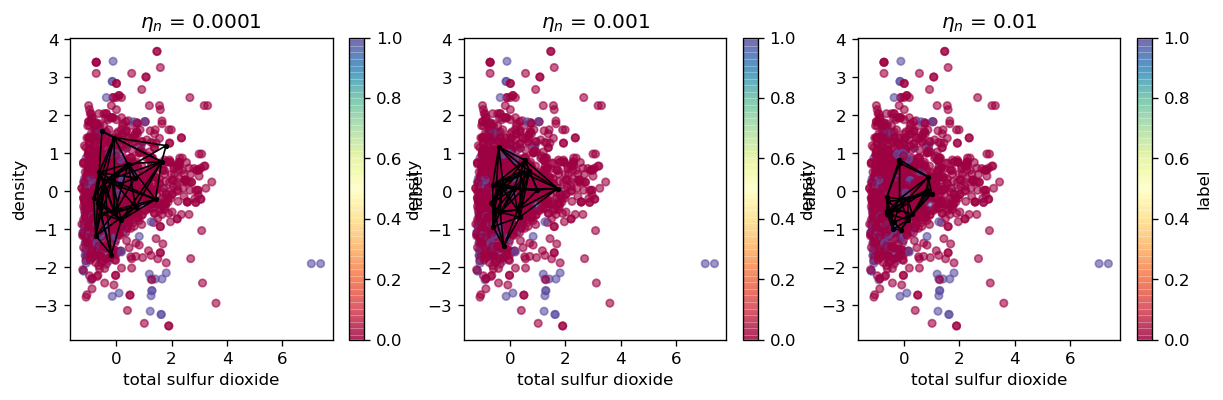

In [51]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("$\eta_n$ = {value}", steps_neighbour)
dims_test2_exp3 = get_2d_position(['total sulfur dioxide', 'density'], list(wine_qualitydf_scaled_df.columns))
show_gng_models(models_neighbour_default_test2_exp3, title_names, dims_test2_exp3, {
    'data': wine_qualitydf_scaled_df,
    'x': 'total sulfur dioxide',
    'y': 'density',
    'label': 'label',
    'cmap': cmap
}, (3, 3))

Nos resultados, nota-se um comportamento interessante, as quantidades maiores de $\eta_n$ acabaram gerando uma estrutura "mais fechada". Isso ocorre já que, para quantidades pequenas de $\eta_n$, é tido que o vencedor tem uma maior importância, o que faz com que seu ajuste seja maior.Tal característica não é mantida quando o valor de $\eta_n$ é tão grande quanto $\eta_b$, o que faz com que o ajuste dos vizinhos seja exatamente o mesmo do vencedor, fazendo com que todos tenham a mesma importância, o que acaba reduzindo o "destaque" dos neurônios que estão vencendo as competições e impede que o processo de aprendizado forme conjuntos de neurônios mais específicos e possivelmente mais distantes de elementos gerais. 

Por uma questão de curiosidade e verificação da continuidade deste comportamento, abaixo é feito a geração de modelos com $\eta_n$ = $10^{-2}$ com diferentes quantidades de `epochs` de modo a ser possível acompanhar a evolução que os mapas estão sofrendo.

> A execução do teste é influenciada pelas inicializações de cada mapa gerado, porém, como pode ser visto nos resultados, o mesmo comportamento de grupos "mais fechados" de neurônios estão presentes em todos os casos apresentados, confirmando assim a influencia do parâmetro $\eta_n$ na formação do mapa. 


In [52]:
model_neighbour_test2_exp3 = algorithms.GrowingNeuralGas(
    n_inputs                     = wine_qualitydf_scaled_df.shape[1] - 1,
    max_nodes                    = 20,
    max_edge_age                 = 100,                # a_max 
    n_iter_before_neuron_added   = 150,                # lambda
    after_split_error_decay_rate = 0.5,                # alpha
    error_decay_rate             = 1 - 0.005,          # beta
    step                         = 10**-2,             # Nb
    neighbour_step               = steps_neighbour[-1] # Nn (= 10^-2)
)

epochs_test2_exp3 = [100, 500, 1000]

# copiando o mesmo modelo na memória (Gera diferentes objetos na memória)
models_neighbour_with_different_epochs_default_test2_exp3 = [copy.deepcopy(model_neighbour_test2_exp3) for i in range(len(epochs_test2_exp3))]

# realizando treinamento dos modelos
[
    model.train(wine_qualitydf_scaled_df.iloc[:, 0:-1], epochs = epoch) for model, epoch in zip(
        models_neighbour_with_different_epochs_default_test2_exp3, epochs_test2_exp3
    )
]

[None, None, None]

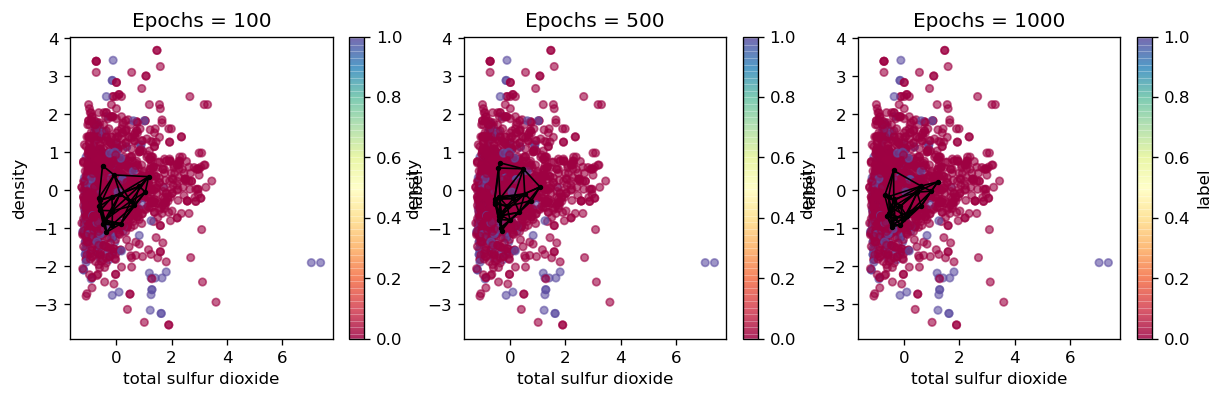

In [53]:
fig = plt.figure(figsize = (12, 12), dpi = 120)

title_names = generate_title_names("Epochs = {value}", epochs_test2_exp3)
show_gng_models(models_neighbour_with_different_epochs_default_test2_exp3, title_names, dims_test2_exp3, {
    'data': wine_qualitydf_scaled_df,
    'x': 'total sulfur dioxide',
    'y': 'density',
    'label': 'label',
    'cmap': cmap
}, (3, 3))